# Task 1: Unsupervised Domain Adaptation - Art to Real-World




## 1. Introduction

This notebook implements and compares multiple Unsupervised Domain Adaptation (UDA) methods on the Office-Home dataset, specifically adapting from **Art (source)** to **Real-World (target)** domains.

**Domain Description:**
- **Source (Art)**: Artistic renderings, paintings, sketches - abstract textures and stylized representations
- **Target (Real-World)**: Real photographs - realistic textures, lighting, and natural appearance

**Methods Compared:**
1. Source-Only Baseline (ERM)
2. DAN (Deep Adaptation Network) - Statistical alignment via MMD
3. DANN (Domain Adversarial Neural Network) - Adversarial alignment
4. CDAN (Conditional Domain Adversarial Network) - Class-aware adversarial alignment
5. Self-Training with Pseudo-labeling

**Theoretical Foundation:**
According to Ben-David et al.'s theory, target error is bounded by:
$\varepsilon_t \le \varepsilon_s + d_H(D_s, D_t) + \lambda$
where reducing domain divergence $d_H$ helps minimize target error.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.svm import LinearSVC
from collections import defaultdict
import os
import random
from PIL import Image
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.backends.cudnn.deterministic = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


Using device: cuda


## 2. Dataset Preparation

Office-home dataset structure:
```
Office-home/
  Clipart/
  Art/
  Real World/
  Photo/
```


In [31]:
import os
import kagglehub

# Download the dataset from KaggleHub
path = kagglehub.dataset_download("karntiwari/home-office-dataset")
print("Dataset downloaded to:", path)
print("Directory contents:", os.listdir(path))

Dataset downloaded to: /kaggle/input/home-office-dataset
Directory contents: ['OfficeHomeDataset_10072016']


In [3]:
class OfficeHomeDataset(Dataset):
    """Office-Home dataset loader"""
    def __init__(self, root_dir, domain, transform=None, return_domain=False):
        self.root_dir = os.path.join(root_dir, domain)
        self.transform = transform
        self.return_domain = return_domain
        self.samples = []
        self.classes = sorted([d for d in os.listdir(self.root_dir) if os.path.isdir(os.path.join(self.root_dir,d))])
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}

        for class_name in self.classes:
            class_path = os.path.join(self.root_dir, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.lower().endswith(('.jpg', '.png', '.jpeg')):
                        self.samples.append((os.path.join(class_path, img_name),
                                           self.class_to_idx[class_name]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        if self.return_domain:
            return image, label, 0  # 0 for source, 1 for target
        return image, label


In [32]:
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# DATA_ROOT = '/kaggle/input/pacs-dataset/dct2_images/dct2_images'
DATA_ROOT = '/kaggle/input/home-office-dataset/OfficeHomeDataset_10072016'

# Load datasets
from torch.utils.data import random_split
full_source = OfficeHomeDataset(DATA_ROOT, 'Art', transform=train_transform)
full_target = OfficeHomeDataset(DATA_ROOT, 'Real World', transform=train_transform)

# Split into train/test (80/20)
source_train_size = int(0.8 * len(full_source))
source_test_size = len(full_source) - source_train_size
source_train, source_test = random_split(full_source, [source_train_size, source_test_size])

target_train_size = int(0.8 * len(full_target))
target_test_size = len(full_target) - target_train_size
target_train, target_test = random_split(full_target, [target_train_size, target_test_size])

NUM_CLASSES = 65
print(f"Number of classes: {NUM_CLASSES}")
print(f"Source train samples: {len(source_train)}")
print(f"Target train samples: {len(target_train)}")
print(f"Target test samples: {len(target_test)}")

Number of classes: 65
Source train samples: 1941
Target train samples: 3485
Target test samples: 872


In [33]:
for _, labels in DataLoader(source_train, batch_size=128):
    print(labels.min().item(), labels.max().item())
    break


0 64


## 3. Model Architecture + Visualization code

We use ResNet-50 pretrained on ImageNet as our backbone for all experiments.


In [34]:
class FeatureExtractor(nn.Module):
    """ResNet-50 feature extractor"""
    def __init__(self):
        super().__init__()
        resnet = models.resnet50(pretrained=True)
        self.feature_dim = 2048

        # Freeze all layers
        for param in resnet.parameters():
            param.requires_grad = False

        # Unfreeze layer4
        for param in resnet.layer4.parameters():
            param.requires_grad = True

        self.features = nn.Sequential(*list(resnet.children())[:-1])
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        return x

class Classifier(nn.Module):
    """Simple classifier head"""
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import seaborn as sns
from PIL import Image
import os

# ImageNet normalization (adjust if you used different values)
IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])

def unnormalize_tensor_image(tensor):
    """Convert normalized tensor to displayable image"""
    if isinstance(tensor, torch.Tensor):
        img = tensor.detach().cpu().numpy()
    else:
        img = np.array(tensor)
    if img.ndim == 3 and img.shape[0] in (1, 3):
        img = np.transpose(img, (1, 2, 0))
    img = (img * IMAGENET_STD) + IMAGENET_MEAN
    img = np.clip(img, 0, 1)
    return img


# ============================================================================
# HELPER: Extract features
# ============================================================================
def extract_features_with_domain(feature_extractor, source_loader, target_loader, max_samples=1000):
    """Extract features from both source and target"""
    feature_extractor.eval()
    device = next(feature_extractor.parameters()).device
    
    def extract_from_loader(loader, max_count):
        feats, labels = [], []
        with torch.no_grad():
            total = 0
            for images, lbls in loader:
                if total >= max_count:
                    break
                images = images.to(device)
                f = feature_extractor(images).cpu().numpy()
                feats.append(f)
                labels.append(lbls.numpy())
                total += f.shape[0]
        return (np.vstack(feats) if feats else np.zeros((0, 2048)),
                np.concatenate(labels) if labels else np.array([]))
    
    s_feats, s_labels = extract_from_loader(source_loader, max_samples // 2)
    t_feats, t_labels = extract_from_loader(target_loader, max_samples // 2)
    
    return s_feats, s_labels, t_feats, t_labels


def get_predictions(feature_extractor, classifier, loader):
    """Get predictions and labels from a loader"""
    feature_extractor.eval()
    classifier.eval()
    device = next(feature_extractor.parameters()).device
    
    all_preds, all_labels, all_probs = [], [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            feats = feature_extractor(images)
            logits = classifier(feats)
            probs = torch.softmax(logits, dim=1)
            preds = logits.argmax(1)
            
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.numpy())
            all_probs.append(probs.cpu().numpy())
    
    return (np.concatenate(all_preds), 
            np.concatenate(all_labels),
            np.vstack(all_probs))


# ============================================================================
# PER-MODEL VISUALIZATION (all details for ONE method)
# ============================================================================
def visualize_single_model(name, feature_extractor, classifier,
                           source_dataset, target_dataset,
                           source_test_loader, target_test_loader,
                           num_classes, class_names=None,
                           max_tsne_samples=1000, show_classes=None,
                           output_dir='viz_outputs'):
    """
    Complete visualization suite for a SINGLE model:
    1. Random source vs target images
    2. Class-colored t-SNE (side-by-side: domain view + class view)
    3. Better confusion matrix (normalized + annotated)
    4. Per-class metrics (F1, precision, recall bar chart)
    
    Saves all to output_dir/model_name/
    """
    print(f"\n{'='*60}")
    print(f"Visualizing: {name}")
    print(f"{'='*60}")
    
    # Create output directory
    model_dir = os.path.join(output_dir, name.replace(' ', '_'))
    os.makedirs(model_dir, exist_ok=True)
    
    if class_names is None:
        class_names = [f'C{i}' for i in range(num_classes)]
    
    # -------------------------
    # 1. Random Images
    # -------------------------
    # print("1/4 Plotting random images...")
    # fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    # src_idx = np.random.choice(len(source_dataset), size=5, replace=False)
    # tgt_idx = np.random.choice(len(target_dataset), size=5, replace=False)
    
    # for i in range(5):
    #     s_img, s_lbl = source_dataset[src_idx[i]][:2]
    #     t_img, t_lbl = target_dataset[tgt_idx[i]][:2]
        
    #     if isinstance(s_img, Image.Image):
    #         s_img = np.asarray(s_img) / 255.0
    #     else:
    #         s_img = unnormalize_tensor_image(s_img)
        
    #     if isinstance(t_img, Image.Image):
    #         t_img = np.asarray(t_img) / 255.0
    #     else:
    #         t_img = unnormalize_tensor_image(t_img)
        
    #     axes[0, i].imshow(s_img)
    #     axes[0, i].set_title(f'Src: {class_names[s_lbl]}', fontsize=9)
    #     axes[0, i].axis('off')
        
    #     axes[1, i].imshow(t_img)
    #     axes[1, i].set_title(f'Tgt: {class_names[t_lbl]}', fontsize=9)
    #     axes[1, i].axis('off')
    
    # plt.suptitle(f'{name} - Source vs Target Samples', fontsize=14, fontweight='bold')
    # plt.tight_layout()
    # plt.savefig(os.path.join(model_dir, 'random_images.png'), dpi=200, bbox_inches='tight')
    # plt.close()
    
    # -------------------------
    # 2. t-SNE (dual view)
    # -------------------------
    print("2/4 Computing t-SNE...")
    s_feats, s_labels, t_feats, t_labels = extract_features_with_domain(
        feature_extractor, source_test_loader, target_test_loader, max_tsne_samples
    )
    
    # Select classes to show
    if show_classes is None:
        if num_classes > 15:
            all_labels = np.concatenate([s_labels, t_labels])
            class_counts = np.bincount(all_labels, minlength=num_classes)
            show_classes = np.argsort(class_counts)[-10:][::-1]
        else:
            show_classes = list(range(num_classes))
    
    # Filter
    s_mask = np.isin(s_labels, show_classes)
    t_mask = np.isin(t_labels, show_classes)
    s_feats_sub = s_feats[s_mask]
    s_labels_sub = s_labels[s_mask]
    t_feats_sub = t_feats[t_mask]
    t_labels_sub = t_labels[t_mask]
    
    if len(s_feats_sub) > 0 and len(t_feats_sub) > 0:
        # Combine
        all_feats = np.vstack([s_feats_sub, t_feats_sub])
        all_labels = np.concatenate([s_labels_sub, t_labels_sub])
        
        # PCA + t-SNE
        if all_feats.shape[1] > 50:
            pca = PCA(n_components=50, random_state=42)
            all_feats = pca.fit_transform(all_feats)
        
        perpl = min(30, max(5, (len(all_feats) - 1) // 3))
        tsne = TSNE(n_components=2, random_state=42, perplexity=perpl,
                   n_iter=1000, init='pca', learning_rate='auto')
        embedded = tsne.fit_transform(all_feats)
        
        # Plot side-by-side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
        n_source = len(s_feats_sub)
        
        # LEFT: Domain view
        ax1.scatter(embedded[:n_source, 0], embedded[:n_source, 1],
                   c='dodgerblue', s=25, alpha=0.6, label='Source', edgecolors='navy', linewidths=0.3)
        ax1.scatter(embedded[n_source:, 0], embedded[n_source:, 1],
                   c='orangered', s=25, alpha=0.6, label='Target', edgecolors='darkred', linewidths=0.3)
        ax1.set_title('Domain Alignment View\n(Are source & target mixed?)', 
                     fontsize=12, fontweight='bold')
        ax1.legend(fontsize=10, loc='best')
        ax1.set_xlabel('t-SNE 1', fontsize=10)
        ax1.set_ylabel('t-SNE 2', fontsize=10)
        ax1.grid(alpha=0.3)
        
        # RIGHT: Class view
        colors = plt.cm.tab10(np.linspace(0, 1, len(show_classes)))
        for i, cls in enumerate(show_classes):
            # Source
            s_idx = np.where(all_labels[:n_source] == cls)[0]
            if len(s_idx) > 0:
                ax2.scatter(embedded[s_idx, 0], embedded[s_idx, 1],
                           c=[colors[i]], marker='o', s=35, alpha=0.7,
                           edgecolors='black', linewidths=0.5,
                           label=f'{class_names[cls]}')
            
            # Target
            t_idx = np.where(all_labels[n_source:] == cls)[0] + n_source
            if len(t_idx) > 0:
                ax2.scatter(embedded[t_idx, 0], embedded[t_idx, 1],
                           c=[colors[i]], marker='x', s=50, alpha=0.85,
                           linewidths=2.0)
        
        ax2.set_title('Class Preservation View\n(Are classes separated? o=src, x=tgt)', 
                     fontsize=12, fontweight='bold')
        ax2.set_xlabel('t-SNE 1', fontsize=10)
        ax2.set_ylabel('t-SNE 2', fontsize=10)
        ax2.grid(alpha=0.3)
        
        # Legend (show only a few classes to avoid clutter)
        handles, labels = ax2.get_legend_handles_labels()
        if len(handles) > 10:
            ax2.legend(handles[:10], labels[:10], loc='center left', 
                      bbox_to_anchor=(1, 0.5), fontsize=8)
        else:
            ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=8)
        
        plt.suptitle(f't-SNE Feature Space: {name}', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, 'tsne_dual_view.png'), dpi=250, bbox_inches='tight')
        plt.close()
    
    # -------------------------
    # 3. Better Confusion Matrix
    # -------------------------
    print("3/4 Generating confusion matrix...")
    preds, labels, probs = get_predictions(feature_extractor, classifier, target_test_loader)
    
    cm = confusion_matrix(labels, preds)
    cm_normalized = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    
    # Raw counts
    show_annot = num_classes <= 20
    sns.heatmap(cm, annot=show_annot, fmt='d', cmap='Blues', ax=ax1,
                cbar_kws={'label': 'Count'}, square=True)
    ax1.set_title(f'{name} - Raw Counts', fontsize=13, fontweight='bold')
    ax1.set_xlabel('Predicted Class', fontsize=11)
    ax1.set_ylabel('True Class', fontsize=11)
    
    # Normalized (shows per-class accuracy on diagonal)
    sns.heatmap(cm_normalized, annot=show_annot, fmt='.2f', cmap='RdYlGn', ax=ax2,
                vmin=0, vmax=1, cbar_kws={'label': 'Proportion'}, square=True)
    ax2.set_title(f'{name} - Normalized (Row %)', fontsize=13, fontweight='bold')
    ax2.set_xlabel('Predicted Class', fontsize=11)
    ax2.set_ylabel('True Class', fontsize=11)
    
    plt.suptitle(f'Confusion Matrix: {name} on Target Domain', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'confusion_matrix.png'), dpi=200, bbox_inches='tight')
    plt.close()
    
    # -------------------------
    # 4. Per-Class Metrics
    # -------------------------
    print("4/4 Computing per-class metrics...")
    
    # Compute per-class metrics
    from sklearn.metrics import precision_recall_fscore_support
    precision, recall, f1, support = precision_recall_fscore_support(
        labels, preds, average=None, zero_division=0
    )
    
    # Find rare classes
    class_counts = np.bincount(labels, minlength=num_classes)
    rarest_3 = np.argsort(class_counts)[:3]
    
    # Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # F1 scores
    ax = axes[0, 0]
    x = np.arange(num_classes)
    bars = ax.bar(x, f1, color='steelblue', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.axhline(f1.mean(), color='green', linestyle='--', linewidth=2, label=f'Mean: {f1.mean():.3f}')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('F1 Score', fontsize=11)
    ax.set_title('Per-Class F1 Scores (Red = 3 rarest classes)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    # Precision
    ax = axes[0, 1]
    bars = ax.bar(x, precision, color='mediumseagreen', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.axhline(precision.mean(), color='darkgreen', linestyle='--', linewidth=2, 
              label=f'Mean: {precision.mean():.3f}')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Precision', fontsize=11)
    ax.set_title('Per-Class Precision', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    # Recall
    ax = axes[1, 0]
    bars = ax.bar(x, recall, color='coral', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.axhline(recall.mean(), color='darkred', linestyle='--', linewidth=2, 
              label=f'Mean: {recall.mean():.3f}')
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Recall', fontsize=11)
    ax.set_title('Per-Class Recall', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    # Sample distribution
    ax = axes[1, 1]
    bars = ax.bar(x, class_counts, color='plum', alpha=0.7)
    for rare_cls in rarest_3:
        bars[rare_cls].set_color('orangered')
        bars[rare_cls].set_alpha(0.9)
    ax.set_xlabel('Class', fontsize=11)
    ax.set_ylabel('Sample Count', fontsize=11)
    ax.set_title('Target Class Distribution (Red = 3 rarest)', fontsize=12, fontweight='bold')
    ax.grid(axis='y', alpha=0.3)
    if num_classes <= 20:
        ax.set_xticks(x)
        ax.set_xticklabels(class_names, rotation=45, ha='right')
    
    plt.suptitle(f'Per-Class Performance Metrics: {name}', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(os.path.join(model_dir, 'per_class_metrics.png'), dpi=200, bbox_inches='tight')
    plt.close()
    
    # Save text summary
    with open(os.path.join(model_dir, 'metrics_summary.txt'), 'w') as f:
        f.write(f"{'='*60}\n")
        f.write(f"Model: {name}\n")
        f.write(f"{'='*60}\n\n")
        f.write(f"Overall Accuracy: {(preds == labels).mean():.4f}\n")
        f.write(f"Macro F1: {f1.mean():.4f}\n")
        f.write(f"Macro Precision: {precision.mean():.4f}\n")
        f.write(f"Macro Recall: {recall.mean():.4f}\n\n")
        f.write(f"Rarest 3 classes: {rarest_3} with counts {class_counts[rarest_3]}\n")
        f.write(f"Rarest classes F1: {f1[rarest_3].mean():.4f}\n\n")
        f.write(f"{'='*60}\n")
        f.write("Per-Class Breakdown:\n")
        f.write(f"{'='*60}\n")
        for i in range(num_classes):
            f.write(f"Class {i:2d} ({class_names[i]:20s}): "
                   f"F1={f1[i]:.3f}, Prec={precision[i]:.3f}, Rec={recall[i]:.3f}, "
                   f"N={class_counts[i]:4d}\n")
    
    print(f"✓ All visualizations saved to: {model_dir}/")
    print(f"  - random_images.png")
    print(f"  - tsne_dual_view.png")
    print(f"  - confusion_matrix.png")
    print(f"  - per_class_metrics.png")
    print(f"  - metrics_summary.txt")


# ============================================================================
# GRID COMPARISONS (compare all methods)
# ============================================================================
def compare_all_methods_tsne_grid(models_dict, source_test_loader, target_test_loader,
                                  num_classes, max_samples=1000, show_classes=None,
                                  savepath='tsne_all_methods_grid.png', ncols=3):
    """
    Grid of class-colored t-SNE for all methods (like CDAN paper Figure 3)
    """
    print("\n" + "="*60)
    print("Creating t-SNE Grid for All Methods")
    print("="*60)
    
    methods = list(models_dict.keys())
    n_methods = len(methods)
    nrows = (n_methods + ncols - 1) // ncols
    
    fig = plt.figure(figsize=(7*ncols, 6*nrows))
    
    for idx, (name, feature_extractor) in enumerate(models_dict.items()):
        print(f"Processing {name} ({idx+1}/{n_methods})...")
        
        # Extract
        s_feats, s_labels, t_feats, t_labels = extract_features_with_domain(
            feature_extractor, source_test_loader, target_test_loader, max_samples
        )
        
        # Select classes
        if show_classes is None:
            if num_classes > 15:
                all_labels = np.concatenate([s_labels, t_labels])
                class_counts = np.bincount(all_labels, minlength=num_classes)
                current_show = np.argsort(class_counts)[-10:][::-1]
            else:
                current_show = list(range(num_classes))
        else:
            current_show = show_classes
        
        # Filter
        s_mask = np.isin(s_labels, current_show)
        t_mask = np.isin(t_labels, current_show)
        s_feats_sub = s_feats[s_mask]
        s_labels_sub = s_labels[s_mask]
        t_feats_sub = t_feats[t_mask]
        t_labels_sub = t_labels[t_mask]
        
        if len(s_feats_sub) == 0 or len(t_feats_sub) == 0:
            continue
        
        # Combine
        all_feats = np.vstack([s_feats_sub, t_feats_sub])
        all_labels = np.concatenate([s_labels_sub, t_labels_sub])
        
        # PCA + t-SNE
        if all_feats.shape[1] > 50:
            pca = PCA(n_components=50, random_state=42)
            all_feats = pca.fit_transform(all_feats)
        
        perpl = min(30, max(5, (len(all_feats) - 1) // 3))
        tsne = TSNE(n_components=2, random_state=42, perplexity=perpl,
                   n_iter=1000, init='pca', learning_rate='auto')
        embedded = tsne.fit_transform(all_feats)
        
        # Plot
        ax = fig.add_subplot(nrows, ncols, idx + 1)
        colors = plt.cm.tab10(np.linspace(0, 1, len(current_show)))
        n_source = len(s_feats_sub)
        
        for i, cls in enumerate(current_show):
            # Source
            s_idx = np.where(all_labels[:n_source] == cls)[0]
            if len(s_idx) > 0:
                ax.scatter(embedded[s_idx, 0], embedded[s_idx, 1],
                          c=[colors[i]], marker='o', s=25, alpha=0.65,
                          edgecolors='black', linewidths=0.3)
            
            # Target
            t_idx = np.where(all_labels[n_source:] == cls)[0] + n_source
            if len(t_idx) > 0:
                ax.scatter(embedded[t_idx, 0], embedded[t_idx, 1],
                          c=[colors[i]], marker='x', s=35, alpha=0.85,
                          linewidths=1.5)
        
        ax.set_title(f'{name}', fontsize=13, fontweight='bold')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    # Legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='gray',
               markersize=9, label='Source', markeredgecolor='black'),
        Line2D([0], [0], marker='x', color='w', markerfacecolor='gray',
               markersize=9, label='Target', markeredgewidth=2)
    ]
    fig.legend(handles=legend_elements, loc='upper right', fontsize=12, framealpha=0.9)
    
    fig.suptitle('t-SNE Comparison: All Methods (Same color = same class)',
                fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    plt.savefig(savepath, dpi=300, bbox_inches='tight')
    print(f"\n✓ Saved: {savepath}")
    plt.show()


def compare_all_methods_heatmap(models_dict, classifiers_dict, target_test_loader,
                                num_classes, class_names=None,
                                savepath='per_class_accuracy_heatmap.png'):
    """
    Heatmap: rows=methods, cols=classes, values=per-class accuracy
    Shows which classes each method struggles with
    """
    print("\n" + "="*60)
    print("Creating Per-Class Accuracy Heatmap")
    print("="*60)
    
    methods = list(models_dict.keys())
    acc_matrix = []
    
    for name in methods:
        print(f"Processing {name}...")
        feat = models_dict[name]
        clsf = classifiers_dict[name]
        
        preds, labels, _ = get_predictions(feat, clsf, target_test_loader)
        
        # Per-class accuracy
        class_accs = []
        for cls_id in range(num_classes):
            cls_mask = labels == cls_id
            if cls_mask.sum() > 0:
                cls_acc = (preds[cls_mask] == labels[cls_mask]).mean()
                class_accs.append(cls_acc)
            else:
                class_accs.append(0.0)
        acc_matrix.append(class_accs)
    
    acc_matrix = np.array(acc_matrix)
    
    # Plot
    fig, ax = plt.subplots(figsize=(max(12, num_classes*0.4), max(6, len(methods)*0.8)))
    
    if class_names is None:
        class_names = [f'C{i}' for i in range(num_classes)]
    
    sns.heatmap(acc_matrix, annot=num_classes <= 20, fmt='.2f', cmap='RdYlGn',
               xticklabels=class_names if num_classes <= 30 else [f'C{i}' for i in range(num_classes)],
               yticklabels=methods, ax=ax, vmin=0, vmax=1,
               cbar_kws={'label': 'Accuracy'}, linewidths=0.5)
    
    ax.set_title('Per-Class Accuracy Heatmap (Rows=Methods, Cols=Classes)',
                fontsize=14, fontweight='bold')
    ax.set_xlabel('Class', fontsize=12)
    ax.set_ylabel('Method', fontsize=12)
    
    if num_classes <= 30:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=250, bbox_inches='tight')
    print(f"✓ Saved: {savepath}")
    plt.show()


def compare_all_methods_confusion(models_dict, classifiers_dict, target_test_loader,
                                  num_classes, savepath='confusion_all_methods_grid.png'):
    """
    Grid of confusion matrices (normalized) for all methods
    """
    print("\n" + "="*60)
    print("Creating Confusion Matrix Grid")
    print("="*60)
    
    methods = list(models_dict.keys())
    n_methods = len(methods)
    ncols = 3
    nrows = (n_methods + ncols - 1) // ncols
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(8*ncols, 7*nrows))
    if n_methods == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for idx, name in enumerate(methods):
        print(f"Processing {name} ({idx+1}/{n_methods})...")
        feat = models_dict[name]
        clsf = classifiers_dict[name]
        
        preds, labels, _ = get_predictions(feat, clsf, target_test_loader)
        cm = confusion_matrix(labels, preds)
        cm_norm = cm.astype('float') / (cm.sum(axis=1, keepdims=True) + 1e-10)
        
        ax = axes[idx]
        show_annot = num_classes <= 15
        sns.heatmap(cm_norm, annot=show_annot, fmt='.2f', cmap='RdYlGn',
                   ax=ax, vmin=0, vmax=1, cbar_kws={'label': 'Proportion'},
                   square=True)
        ax.set_title(f'{name}\nAcc: {(preds==labels).mean():.3f}', 
                    fontsize=12, fontweight='bold')
        ax.set_xlabel('Predicted', fontsize=10)
        ax.set_ylabel('True', fontsize=10)
    
    # Hide empty subplots
    for idx in range(n_methods, len(axes)):
        fig.delaxes(axes[idx])
    
    plt.suptitle('Confusion Matrices: All Methods (Normalized by Row)',
                fontsize=15, fontweight='bold')
    plt.tight_layout()
    plt.savefig(savepath, dpi=250, bbox_inches='tight')
    print(f"✓ Saved: {savepath}")
    plt.show()


def compare_rare_class_performance(models_dict, classifiers_dict, target_test_loader,
                                   num_classes, n_rare=3, class_names=None,
                                   savepath='rare_class_comparison.png'):
    """
    Compare F1 scores on the N rarest classes across all methods
    Shows negative transfer effects
    """
    print("\n" + "="*60)
    print(f"Comparing Performance on {n_rare} Rarest Classes")
    print("="*60)
    
    methods = list(models_dict.keys())
    
    # Get class distribution from target
    all_labels = []
    for _, labels in target_test_loader:
        all_labels.extend(labels.numpy())
    all_labels = np.array(all_labels)
    
    class_counts = np.bincount(all_labels, minlength=num_classes)
    rarest_classes = np.argsort(class_counts)[:n_rare]
    
    print(f"Rarest {n_rare} classes: {rarest_classes}")
    print(f"Class counts: {class_counts[rarest_classes]}")
    
    if class_names is None:
        class_names = [f'Class {i}' for i in range(num_classes)]
    
    # Collect F1 scores for each method on rare classes
    rare_f1_matrix = []
    overall_f1_list = []
    
    for name in methods:
        print(f"Evaluating {name}...")
        feat = models_dict[name]
        clsf = classifiers_dict[name]
        
        preds, labels, _ = get_predictions(feat, clsf, target_test_loader)
        
        # Per-class F1
        f1_scores = f1_score(labels, preds, average=None, zero_division=0)
        rare_f1_matrix.append(f1_scores[rarest_classes])
        overall_f1_list.append(f1_scores.mean())
    
    rare_f1_matrix = np.array(rare_f1_matrix)
    
    # Plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Bar chart: F1 on rare classes
    x = np.arange(len(methods))
    width = 0.25
    
    for i, rare_cls in enumerate(rarest_classes):
        offset = width * (i - n_rare//2)
        bars = ax1.bar(x + offset, rare_f1_matrix[:, i], width, 
                      label=f'{class_names[rare_cls]} (n={class_counts[rare_cls]})',
                      alpha=0.8)
    
    ax1.set_xlabel('Method', fontsize=12)
    ax1.set_ylabel('F1 Score', fontsize=12)
    ax1.set_title(f'F1 Scores on {n_rare} Rarest Classes', fontsize=13, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(methods, rotation=45, ha='right')
    ax1.legend(fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    ax1.axhline(0.5, color='red', linestyle='--', linewidth=1, alpha=0.5)
    
    # Scatter: overall F1 vs rare class average F1
    rare_f1_avg = rare_f1_matrix.mean(axis=1)
    
    ax2.scatter(overall_f1_list, rare_f1_avg, s=150, alpha=0.7, c=range(len(methods)),
               cmap='viridis', edgecolors='black', linewidths=2)
    
    for i, name in enumerate(methods):
        ax2.annotate(name, (overall_f1_list[i], rare_f1_avg[i]),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)
    
    ax2.plot([0, 1], [0, 1], 'r--', linewidth=2, alpha=0.5, label='y=x (equal performance)')
    ax2.set_xlabel('Overall Macro F1', fontsize=12)
    ax2.set_ylabel(f'Average F1 on {n_rare} Rarest Classes', fontsize=12)
    ax2.set_title('Overall vs Rare Class Performance\n(Above line = rare classes benefit)',
                 fontsize=13, fontweight='bold')
    ax2.legend(fontsize=9)
    ax2.grid(alpha=0.3)
    ax2.set_xlim([0, 1])
    ax2.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.savefig(savepath, dpi=250, bbox_inches='tight')
    print(f"✓ Saved: {savepath}")
    plt.show()
    
    # Print summary
    print("\n" + "-"*60)
    print("RARE CLASS PERFORMANCE SUMMARY")
    print("-"*60)
    for i, name in enumerate(methods):
        print(f"{name:20s} | Overall F1: {overall_f1_list[i]:.4f} | "
              f"Rare Avg F1: {rare_f1_avg[i]:.4f} | "
              f"Diff: {rare_f1_avg[i] - overall_f1_list[i]:+.4f}")
    print("-"*60)


# ============================================================================
# MASTER FUNCTION: Run everything
# ============================================================================
def run_complete_visualization_suite(models_dict, classifiers_dict,
                                     source_dataset, target_dataset,
                                     source_test_loader, target_test_loader,
                                     num_classes, class_names=None,
                                     output_dir='viz_outputs',
                                     max_tsne_samples=1000,
                                     show_classes=None):
    """
    Run EVERYTHING:
    1. Per-model detailed visualizations (one folder per model)
    2. Grid comparisons (t-SNE, confusion matrices)
    3. Heatmaps (per-class accuracy across methods)
    4. Rare class analysis
    
    This is the ONE function you call after training all models.
    
    Args:
        models_dict: {'Method Name': feature_extractor, ...}
        classifiers_dict: {'Method Name': classifier, ...}
        source_dataset: source Dataset object
        target_dataset: target Dataset object
        source_test_loader: source test DataLoader
        target_test_loader: target test DataLoader
        num_classes: number of classes
        class_names: list of class names (optional)
        output_dir: where to save everything
        max_tsne_samples: max samples for t-SNE (reduce if too slow)
        show_classes: subset of classes to show in t-SNE (None = auto)
    """
    
    print("\n" + "="*70)
    print("COMPLETE VISUALIZATION SUITE")
    print("="*70)
    print(f"Number of methods: {len(models_dict)}")
    print(f"Output directory: {output_dir}")
    print("="*70 + "\n")
    
    os.makedirs(output_dir, exist_ok=True)
    
    # ========================================
    # PART 1: Per-model detailed viz
    # ========================================
    print("\n" + "█"*70)
    print("PART 1: PER-MODEL DETAILED VISUALIZATIONS")
    print("█"*70)
    
    for name in models_dict.keys():
        visualize_single_model(
            name, 
            models_dict[name], 
            classifiers_dict[name],
            source_dataset, 
            target_dataset,
            source_test_loader, 
            target_test_loader,
            num_classes, 
            class_names=class_names,
            max_tsne_samples=max_tsne_samples,
            show_classes=show_classes,
            output_dir=output_dir
        )
    
    # ========================================
    # PART 2: Grid comparisons
    # ========================================
    print("\n" + "█"*70)
    print("PART 2: GRID COMPARISONS")
    print("█"*70)
    
    # t-SNE grid
    compare_all_methods_tsne_grid(
        models_dict, 
        source_test_loader, 
        target_test_loader,
        num_classes, 
        max_samples=max_tsne_samples,
        show_classes=show_classes,
        savepath=os.path.join(output_dir, 'tsne_all_methods_grid.png'),
        ncols=3
    )
    
    # Confusion matrix grid
    compare_all_methods_confusion(
        models_dict, 
        classifiers_dict,
        target_test_loader,
        num_classes,
        savepath=os.path.join(output_dir, 'confusion_all_methods_grid.png')
    )
    
    # ========================================
    # PART 3: Heatmaps and comparisons
    # ========================================
    print("\n" + "█"*70)
    print("PART 3: COMPARATIVE ANALYSES")
    print("█"*70)
    
    # Per-class accuracy heatmap
    compare_all_methods_heatmap(
        models_dict, 
        classifiers_dict,
        target_test_loader,
        num_classes,
        class_names=class_names,
        savepath=os.path.join(output_dir, 'per_class_accuracy_heatmap.png')
    )
    
    # Rare class performance
    compare_rare_class_performance(
        models_dict, 
        classifiers_dict,
        target_test_loader,
        num_classes,
        n_rare=3,
        class_names=class_names,
        savepath=os.path.join(output_dir, 'rare_class_comparison.png')
    )
    
    print("\n" + "="*70)
    print("✓ COMPLETE VISUALIZATION SUITE FINISHED")
    print("="*70)
    print(f"\nAll results saved to: {output_dir}/")
    print("\nGenerated files:")
    print("  Per-model folders:")
    for name in models_dict.keys():
        folder_name = name.replace(' ', '_')
        print(f"    - {folder_name}/")
        print(f"      ├── random_images.png")
        print(f"      ├── tsne_dual_view.png")
        print(f"      ├── confusion_matrix.png")
        print(f"      ├── per_class_metrics.png")
        print(f"      └── metrics_summary.txt")
    print("\n  Grid comparisons:")
    print(f"    - tsne_all_methods_grid.png")
    print(f"    - confusion_all_methods_grid.png")
    print(f"    - per_class_accuracy_heatmap.png")
    print(f"    - rare_class_comparison.png")
    print("="*70 + "\n")

## 4. Experiment 1: Source-Only Baseline

Train only on source domain (Art) using standard ERM (Empirical Risk Minimization).
This establishes our baseline and quantifies the domain shift.


In [36]:
def train_source_only(source_loader, num_epochs=20, lr=1e-3):
    """Train source-only baseline"""

    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(feature_extractor.feature_dim, NUM_CLASSES).to(device)
    optimizer = optim.Adam(list(feature_extractor.parameters()) +
                          list(classifier.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in tqdm(source_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            features = feature_extractor(images)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

        acc = 100. * correct / total
        tqdm.write(f"Epoch {epoch+1}: Loss={total_loss/len(source_loader):.4f}, Acc={acc:.2f}%")

    return feature_extractor, classifier


In [37]:
def evaluate(feature_extractor, classifier, data_loader):
    """Evaluate model on a dataset"""
    feature_extractor.eval()
    classifier.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_features = []

    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)
            outputs = classifier(features)
            _, predicted = outputs.max(1)

            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_features.append(features.cpu().numpy())

    accuracy = 100. * correct / total
    all_features = np.vstack(all_features)

    return accuracy, np.array(all_preds), np.array(all_labels), all_features


In [38]:
# Train source-only model
print("Training Source-Only Baseline...")
source_loader = DataLoader(source_train, batch_size=32, shuffle=True, num_workers=4)
source_test_loader = DataLoader(source_test, batch_size=32, shuffle=False, num_workers=4)
target_test_loader = DataLoader(target_test, batch_size=32, shuffle=False, num_workers=4)

feat_ext_source, cls_source = train_source_only(source_loader, num_epochs=20)

# Evaluate
source_acc, _, _, _ = evaluate(feat_ext_source, cls_source, source_test_loader)
target_acc, target_preds, target_labels, _ = evaluate(feat_ext_source, cls_source, target_test_loader)

print(f"\n{'='*50}")
print(f"SOURCE-ONLY BASELINE RESULTS:")
print(f"Source Test Accuracy: {source_acc:.2f}%")
print(f"Target Test Accuracy: {target_acc:.2f}%")
print(f"Accuracy Drop: {source_acc - target_acc:.2f}%")
print(f"{'='*50}\n")

# Save for later comparison
results = {
    'Source-Only': {'source_acc': source_acc, 'target_acc': target_acc}
}


Training Source-Only Baseline...


Epoch 1/20: 100%|██████████| 61/61 [00:12<00:00,  4.93it/s]


Epoch 1: Loss=2.8864, Acc=32.92%


Epoch 2/20: 100%|██████████| 61/61 [00:12<00:00,  5.07it/s]


Epoch 2: Loss=1.7478, Acc=53.53%


Epoch 3/20: 100%|██████████| 61/61 [00:12<00:00,  4.85it/s]


Epoch 3: Loss=1.2509, Acc=65.74%


Epoch 4/20: 100%|██████████| 61/61 [00:11<00:00,  5.15it/s]


Epoch 4: Loss=0.9356, Acc=73.26%


Epoch 5/20: 100%|██████████| 61/61 [00:11<00:00,  5.41it/s]


Epoch 5: Loss=0.6624, Acc=79.65%


Epoch 6/20: 100%|██████████| 61/61 [00:11<00:00,  5.42it/s]


Epoch 6: Loss=0.5973, Acc=82.59%


Epoch 7/20: 100%|██████████| 61/61 [00:11<00:00,  5.40it/s]


Epoch 7: Loss=0.4641, Acc=85.68%


Epoch 8/20: 100%|██████████| 61/61 [00:11<00:00,  5.28it/s]


Epoch 8: Loss=0.3201, Acc=90.42%


Epoch 9/20: 100%|██████████| 61/61 [00:11<00:00,  5.22it/s]


Epoch 9: Loss=0.3055, Acc=90.57%


Epoch 10/20: 100%|██████████| 61/61 [00:11<00:00,  5.15it/s]


Epoch 10: Loss=0.2978, Acc=91.60%


Epoch 11/20: 100%|██████████| 61/61 [00:11<00:00,  5.14it/s]


Epoch 11: Loss=0.2325, Acc=93.46%


Epoch 12/20: 100%|██████████| 61/61 [00:11<00:00,  5.23it/s]


Epoch 12: Loss=0.1713, Acc=95.00%


Epoch 13/20: 100%|██████████| 61/61 [00:11<00:00,  5.36it/s]


Epoch 13: Loss=0.1528, Acc=95.62%


Epoch 14/20: 100%|██████████| 61/61 [00:11<00:00,  5.37it/s]


Epoch 14: Loss=0.1756, Acc=95.05%


Epoch 15/20: 100%|██████████| 61/61 [00:11<00:00,  5.38it/s]


Epoch 15: Loss=0.1432, Acc=95.88%


Epoch 16/20: 100%|██████████| 61/61 [00:11<00:00,  5.32it/s]


Epoch 16: Loss=0.1270, Acc=96.03%


Epoch 17/20: 100%|██████████| 61/61 [00:11<00:00,  5.26it/s]


Epoch 17: Loss=0.1246, Acc=96.39%


Epoch 18/20: 100%|██████████| 61/61 [00:11<00:00,  5.27it/s]


Epoch 18: Loss=0.1386, Acc=95.72%


Epoch 19/20: 100%|██████████| 61/61 [00:11<00:00,  5.22it/s]


Epoch 19: Loss=0.0973, Acc=97.22%


Epoch 20/20: 100%|██████████| 61/61 [00:11<00:00,  5.23it/s]


Epoch 20: Loss=0.0854, Acc=97.42%

SOURCE-ONLY BASELINE RESULTS:
Source Test Accuracy: 63.17%
Target Test Accuracy: 57.22%
Accuracy Drop: 5.94%



### Analysis: Source-Only Baseline

**Observations:**
- Large accuracy drop from source to target demonstrates significant domain shift
- Art domain (paintings, sketches) has different visual characteristics than Real-World (photographs)
- Key differences: texture realism, lighting conditions, color distributions

**Theoretical Connection:**
According to Ben-David et al., this drop reflects the domain divergence term d_H(D_s, D_t) in the error bound.

## 5. Experiment 2: Domain-Alignment Based Adaptation

In [40]:
def adaptation_lambda(progress, gamma=10.0):
    """
    progress: float in [0,1] indicating fraction of total training completed
    returns lambda in [0,1] using logistic schedule from DAN/DANN papers
    """
    p = float(np.clip(progress, 0.0, 1.0))
    return 2.0 / (1.0 + np.exp(-gamma * p)) - 1.0

### 5.1 Domain Adaptation Network (DAN) - MMD based alignment

In [41]:
def mmd_loss(source_features, target_features, kernel_mul=2.0, kernel_num=5):
    batch_size = source_features.size(0)
    total = torch.cat([source_features, target_features], dim=0)
    n = total.size(0)
    
    # Pairwise distances
    total0 = total.unsqueeze(0).expand(n, n, total.size(1))
    total1 = total.unsqueeze(1).expand(n, n, total.size(1))
    L2_distance = ((total0 - total1) ** 2).sum(2)
    
    # Bandwidth using median heuristic
    bandwidth = torch.median(L2_distance[L2_distance > 0])
    bandwidth = bandwidth / (kernel_mul ** (kernel_num // 2))
    
    # Multi-kernel
    bandwidth_list = [bandwidth * (kernel_mul ** i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / (2.0 * bw + 1e-8)) for bw in bandwidth_list]
    kernels = sum(kernel_val) / len(kernel_val)  # Average kernels
    
    # MMD computation
    XX = kernels[:batch_size, :batch_size].mean()
    YY = kernels[batch_size:, batch_size:].mean()
    XY = kernels[:batch_size, batch_size:].mean()
    
    return XX + YY - 2 * XY


In [42]:
def train_dan(source_loader, target_loader, num_epochs=20, lr=1e-3, base_mmd_weight=1.0, device=device):
    """
    DAN training with logistic lambda schedule.
    - base_mmd_weight: final scale of MMD (you can set 0.5 if you want half-strength)
    """
    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(2048, NUM_CLASSES).to(device)

    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(classifier.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    total_steps = num_epochs * len(source_loader)
    step = 0

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()

        epoch_loss = 0.0
        epoch_cls_loss = 0.0
        epoch_mmd_loss = 0.0
        correct = 0
        total = 0

        target_iter = iter(target_loader)
        for images_s, labels_s in tqdm(source_loader, desc=f"DAN Epoch {epoch+1}/{num_epochs}"):
            step += 1
            progress = step / float(total_steps)
            lam = adaptation_lambda(progress)       # in [0,1]
            mmd_weight = base_mmd_weight * lam      # ramp MMD effect

            try:
                images_t, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                images_t, _ = next(target_iter)

            images_s = images_s.to(device); labels_s = labels_s.to(device)
            images_t = images_t.to(device)

            features_s = feature_extractor(images_s)
            features_t = feature_extractor(images_t)
            outputs_s = classifier(features_s)

            cls_loss = criterion(outputs_s, labels_s)
            mmd = mmd_loss(features_s, features_t)

            loss = cls_loss + mmd_weight * mmd

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            epoch_cls_loss += cls_loss.item()
            epoch_mmd_loss += mmd.item()
            _, predicted = outputs_s.max(1)
            correct += predicted.eq(labels_s).sum().item()
            total += labels_s.size(0)

        avg_loss = epoch_loss / len(source_loader)
        avg_cls = epoch_cls_loss / len(source_loader)
        avg_mmd = epoch_mmd_loss / len(source_loader)
        acc = 100.0 * correct / total
        tqdm.write(f" Loss={avg_loss:.4f} CLS={avg_cls:.4f} MMD={avg_mmd:.6f} Acc={acc:.2f}% (lam={lam:.4f})")

    return feature_extractor, classifier

In [43]:
print("Training DAN (Deep Adaptation Network)...")
target_loader = DataLoader(target_train, batch_size=32, shuffle=True, num_workers=4)
feat_ext_dan, cls_dan = train_dan(source_loader, target_loader, num_epochs=20)

# Evaluate DAN
source_acc_dan, _, _, _ = evaluate(feat_ext_dan, cls_dan, source_test_loader)
target_acc_dan, _, _, _ = evaluate(feat_ext_dan, cls_dan, target_test_loader)

print(f"\n{'='*50}")
print(f"DAN RESULTS:")
print(f"Source Test Accuracy: {source_acc_dan:.2f}%")
print(f"Target Test Accuracy: {target_acc_dan:.2f}%")
print(f"Accuracy Drop: {source_acc_dan - target_acc_dan:.2f}%")
print(f"{'='*50}\n")

# print(f"DAN - Source Acc: {source_acc_dan:.2f}%, Target Acc: {target_acc_dan:.2f}%")
results['DAN'] = {'source_acc': source_acc_dan, 'target_acc': target_acc_dan}


Training DAN (Deep Adaptation Network)...


DAN Epoch 1/20: 100%|██████████| 61/61 [00:32<00:00,  1.87it/s]

 Loss=2.9327 CLS=2.9306 MMD=0.017017 Acc=32.72% (lam=0.2449)



DAN Epoch 2/20: 100%|██████████| 61/61 [00:29<00:00,  2.08it/s]

 Loss=1.7223 CLS=1.7172 MMD=0.014121 Acc=54.77% (lam=0.4621)



DAN Epoch 3/20: 100%|██████████| 61/61 [00:28<00:00,  2.11it/s]

 Loss=1.2177 CLS=1.2101 MMD=0.013653 Acc=67.59% (lam=0.6351)



DAN Epoch 4/20: 100%|██████████| 61/61 [00:28<00:00,  2.11it/s]

 Loss=0.8986 CLS=0.8893 MMD=0.013114 Acc=73.57% (lam=0.7616)



DAN Epoch 5/20: 100%|██████████| 61/61 [00:30<00:00,  1.98it/s]

 Loss=0.6839 CLS=0.6731 MMD=0.013241 Acc=79.86% (lam=0.8483)



DAN Epoch 6/20: 100%|██████████| 61/61 [00:30<00:00,  2.02it/s]

 Loss=0.5313 CLS=0.5196 MMD=0.013364 Acc=84.34% (lam=0.9051)



DAN Epoch 7/20: 100%|██████████| 61/61 [00:30<00:00,  2.01it/s]

 Loss=0.4810 CLS=0.4687 MMD=0.013255 Acc=85.52% (lam=0.9414)



DAN Epoch 8/20: 100%|██████████| 61/61 [00:30<00:00,  2.00it/s]

 Loss=0.3681 CLS=0.3554 MMD=0.013262 Acc=89.39% (lam=0.9640)



DAN Epoch 9/20: 100%|██████████| 61/61 [00:29<00:00,  2.07it/s]

 Loss=0.3234 CLS=0.3108 MMD=0.013025 Acc=91.19% (lam=0.9780)



DAN Epoch 10/20: 100%|██████████| 61/61 [00:30<00:00,  2.03it/s]

 Loss=0.2748 CLS=0.2618 MMD=0.013263 Acc=92.22% (lam=0.9866)



DAN Epoch 11/20: 100%|██████████| 61/61 [00:29<00:00,  2.05it/s]

 Loss=0.2291 CLS=0.2157 MMD=0.013538 Acc=93.56% (lam=0.9919)



DAN Epoch 12/20: 100%|██████████| 61/61 [00:29<00:00,  2.07it/s]

 Loss=0.1963 CLS=0.1831 MMD=0.013365 Acc=94.44% (lam=0.9951)



DAN Epoch 13/20: 100%|██████████| 61/61 [00:30<00:00,  2.03it/s]

 Loss=0.1522 CLS=0.1389 MMD=0.013429 Acc=96.39% (lam=0.9970)



DAN Epoch 14/20: 100%|██████████| 61/61 [00:28<00:00,  2.12it/s]

 Loss=0.1487 CLS=0.1356 MMD=0.013145 Acc=95.93% (lam=0.9982)



DAN Epoch 15/20: 100%|██████████| 61/61 [00:30<00:00,  1.99it/s]

 Loss=0.1495 CLS=0.1368 MMD=0.012738 Acc=96.24% (lam=0.9989)



DAN Epoch 16/20: 100%|██████████| 61/61 [00:30<00:00,  1.99it/s]

 Loss=0.1296 CLS=0.1164 MMD=0.013231 Acc=96.60% (lam=0.9993)



DAN Epoch 17/20: 100%|██████████| 61/61 [00:30<00:00,  2.01it/s]

 Loss=0.1369 CLS=0.1239 MMD=0.012999 Acc=96.60% (lam=0.9996)



DAN Epoch 18/20: 100%|██████████| 61/61 [00:29<00:00,  2.06it/s]

 Loss=0.1419 CLS=0.1288 MMD=0.013164 Acc=96.24% (lam=0.9998)



DAN Epoch 19/20: 100%|██████████| 61/61 [00:30<00:00,  1.98it/s]

 Loss=0.0799 CLS=0.0667 MMD=0.013275 Acc=98.04% (lam=0.9999)



DAN Epoch 20/20: 100%|██████████| 61/61 [00:29<00:00,  2.07it/s]


 Loss=0.0973 CLS=0.0845 MMD=0.012833 Acc=97.99% (lam=0.9999)

DAN RESULTS:
Source Test Accuracy: 60.91%
Target Test Accuracy: 55.50%
Accuracy Drop: 5.40%



### 5.2 Domain Adversarial Neural Network (DANN)


In [44]:
class GradientReversalLayer(torch.autograd.Function):
    """Gradient Reversal Layer"""
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.alpha * grad_output, None

class DomainDiscriminator(nn.Module):
    """Domain discriminator for DANN"""
    def __init__(self, input_dim):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )

    def forward(self, x):
        return self.fc(x)

In [45]:
def train_dann(source_loader, target_loader, num_epochs=20, lr=1e-3, base_domain_weight=1.0, device=device):
    """
    DANN training:
    - base_domain_weight: final scale of adversarial domain loss (ramped by schedule)
    """
    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(2048, NUM_CLASSES).to(device)
    discriminator = DomainDiscriminator(2048).to(device)

    optimizer = optim.Adam(list(feature_extractor.parameters()) + list(classifier.parameters()) + list(discriminator.parameters()), lr=lr)
    cls_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()

    total_steps = num_epochs * len(source_loader)
    step = 0

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()
        discriminator.train()

        epoch_cls = 0.0
        epoch_dom = 0.0
        correct = 0
        total = 0

        target_iter = iter(target_loader)
        for images_s, labels_s in tqdm(source_loader, desc=f"DANN Epoch {epoch+1}/{num_epochs}"):
            step += 1
            progress = step / float(total_steps)
            lam = adaptation_lambda(progress)
            domain_weight = base_domain_weight * lam
            grl_alpha = lam  # use same schedule for GRL magnitude

            try:
                images_t, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                images_t, _ = next(target_iter)

            images_s = images_s.to(device); labels_s = labels_s.to(device)
            images_t = images_t.to(device)

            # Forward
            features_s = feature_extractor(images_s)
            features_t = feature_extractor(images_t)

            outputs_s = classifier(features_s)
            cls_loss = cls_criterion(outputs_s, labels_s)

            # Domain preds with GRL (apply alpha)
            rf_s = GradientReversalLayer.apply(features_s, grl_alpha)
            rf_t = GradientReversalLayer.apply(features_t, grl_alpha)

            domain_pred_s = discriminator(rf_s)
            domain_pred_t = discriminator(rf_t)

            domain_labels_s = torch.zeros(domain_pred_s.size(0), 1, device=device)
            domain_labels_t = torch.ones(domain_pred_t.size(0), 1, device=device)

            domain_loss = domain_criterion(domain_pred_s, domain_labels_s) + domain_criterion(domain_pred_t, domain_labels_t)

            total_loss = cls_loss + domain_weight * domain_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_cls += cls_loss.item()
            epoch_dom += domain_loss.item()
            _, predicted = outputs_s.max(1)
            correct += predicted.eq(labels_s).sum().item()
            total += labels_s.size(0)

        avg_cls = epoch_cls / len(source_loader)
        avg_dom = epoch_dom / len(source_loader)
        acc = 100.0 * correct / total
        tqdm.write(f"CLS={avg_cls:.4f} DOM={avg_dom:.6f} Acc={acc:.2f}% (lam={lam:.4f})")

    return feature_extractor, classifier

In [46]:
print("Training DANN (Domain Adversarial Neural Network)...")
feat_ext_dann, cls_dann = train_dann(source_loader, target_loader, num_epochs=20)

# Evaluate DANN
source_acc_dann, _, _, _ = evaluate(feat_ext_dann, cls_dann, source_test_loader)
target_acc_dann, _, _, _ = evaluate(feat_ext_dann, cls_dann, target_test_loader)

print(f"\n{'='*50}")
print(f"DANN RESULTS:")
print(f"Source Test Accuracy: {source_acc_dann:.2f}%")
print(f"Target Test Accuracy: {target_acc_dann:.2f}%")
print(f"Accuracy Drop: {source_acc_dann - target_acc_dann:.2f}%")
print(f"{'='*50}\n")

# print(f"DANN - Source Acc: {source_acc_dann:.2f}%, Target Acc: {target_acc_dann:.2f}%")
results['DANN'] = {'source_acc': source_acc_dann, 'target_acc': target_acc_dann}


Training DANN (Domain Adversarial Neural Network)...


DANN Epoch 1/20: 100%|██████████| 61/61 [00:32<00:00,  1.85it/s]

CLS=3.0080 DOM=1.444207 Acc=31.58% (lam=0.2449)



DANN Epoch 2/20: 100%|██████████| 61/61 [00:30<00:00,  2.02it/s]

CLS=1.7430 DOM=1.400511 Acc=54.77% (lam=0.4621)



DANN Epoch 3/20: 100%|██████████| 61/61 [00:31<00:00,  1.93it/s]

CLS=1.2909 DOM=1.389268 Acc=64.30% (lam=0.6351)



DANN Epoch 4/20: 100%|██████████| 61/61 [00:31<00:00,  1.93it/s]

CLS=0.8783 DOM=1.387708 Acc=74.65% (lam=0.7616)



DANN Epoch 5/20: 100%|██████████| 61/61 [00:29<00:00,  2.05it/s]

CLS=0.6690 DOM=1.382656 Acc=80.58% (lam=0.8483)



DANN Epoch 6/20: 100%|██████████| 61/61 [00:30<00:00,  2.02it/s]

CLS=0.5560 DOM=1.378017 Acc=82.69% (lam=0.9051)



DANN Epoch 7/20: 100%|██████████| 61/61 [00:30<00:00,  2.00it/s]

CLS=0.4986 DOM=1.377732 Acc=84.60% (lam=0.9414)



DANN Epoch 8/20: 100%|██████████| 61/61 [00:31<00:00,  1.93it/s]

CLS=0.3844 DOM=1.375422 Acc=88.87% (lam=0.9640)



DANN Epoch 9/20: 100%|██████████| 61/61 [00:31<00:00,  1.91it/s]

CLS=0.2768 DOM=1.380144 Acc=90.93% (lam=0.9780)



DANN Epoch 10/20: 100%|██████████| 61/61 [00:31<00:00,  1.93it/s]

CLS=0.2867 DOM=1.381800 Acc=92.07% (lam=0.9866)



DANN Epoch 11/20: 100%|██████████| 61/61 [00:31<00:00,  1.92it/s]


CLS=0.1585 DOM=1.379151 Acc=95.41% (lam=0.9919)


DANN Epoch 12/20: 100%|██████████| 61/61 [00:30<00:00,  1.99it/s]

CLS=0.1584 DOM=1.383853 Acc=95.52% (lam=0.9951)



DANN Epoch 13/20: 100%|██████████| 61/61 [00:30<00:00,  2.00it/s]

CLS=0.1646 DOM=1.382770 Acc=95.52% (lam=0.9970)



DANN Epoch 14/20: 100%|██████████| 61/61 [00:30<00:00,  2.00it/s]

CLS=0.1680 DOM=1.385523 Acc=94.59% (lam=0.9982)



DANN Epoch 15/20: 100%|██████████| 61/61 [00:32<00:00,  1.90it/s]


CLS=0.1867 DOM=1.384078 Acc=94.08% (lam=0.9989)


DANN Epoch 16/20: 100%|██████████| 61/61 [00:31<00:00,  1.92it/s]

CLS=0.2161 DOM=1.381142 Acc=93.66% (lam=0.9993)



DANN Epoch 17/20: 100%|██████████| 61/61 [00:32<00:00,  1.90it/s]

CLS=0.1985 DOM=1.384238 Acc=94.38% (lam=0.9996)



DANN Epoch 18/20: 100%|██████████| 61/61 [00:32<00:00,  1.89it/s]

CLS=0.1133 DOM=1.382393 Acc=96.91% (lam=0.9998)



DANN Epoch 19/20: 100%|██████████| 61/61 [00:30<00:00,  2.01it/s]

CLS=0.1114 DOM=1.380531 Acc=97.17% (lam=0.9999)



DANN Epoch 20/20: 100%|██████████| 61/61 [00:29<00:00,  2.09it/s]


CLS=0.1134 DOM=1.384182 Acc=97.11% (lam=0.9999)

DANN RESULTS:
Source Test Accuracy: 63.79%
Target Test Accuracy: 57.22%
Accuracy Drop: 6.56%



### 5.3 Conditional Domain Adversarial Network (CDAN)


In [48]:
def train_cdan(source_loader, target_loader, num_epochs=20, lr=1e-3, base_domain_weight=1.0, device=device):
    """Train CDAN model with class-aware conditioning"""
    feature_extractor = FeatureExtractor().to(device)
    classifier = Classifier(2048, NUM_CLASSES).to(device)
    # Discriminator takes concatenated features and predictions
    discriminator = DomainDiscriminator(2048 + NUM_CLASSES).to(device)

    optimizer = optim.Adam(list(feature_extractor.parameters()) +
                          list(classifier.parameters()) +
                          list(discriminator.parameters()), lr=lr)

    cls_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()
    total_steps = num_epochs * len(source_loader)
    step = 0

    for epoch in range(num_epochs):
        feature_extractor.train()
        classifier.train()
        discriminator.train()

        epoch_cls = 0.0
        epoch_dom = 0.0
        correct = 0
        total = 0

        target_iter = iter(target_loader)

        for images_s, labels_s in tqdm(source_loader, desc=f"CDAN Epoch {epoch+1}/{num_epochs}"):
            step += 1
            progress = step / float(total_steps)
            lam = adaptation_lambda(progress)
            domain_weight = base_domain_weight * lam
            grl_alpha = lam
            try:
                images_t, _ = next(target_iter)
            except StopIteration:
                target_iter = iter(target_loader)
                images_t, _ = next(target_iter)

            images_s, labels_s = images_s.to(device), labels_s.to(device)
            images_t = images_t.to(device)

            # Forward
            features_s = feature_extractor(images_s)
            features_t = feature_extractor(images_t)

            outputs_s = classifier(features_s)
            outputs_t = classifier(features_t)

            # Classification loss
            cls_loss = cls_criterion(outputs_s, labels_s)

            # Class-aware domain adversarial loss
            softmax_s = torch.softmax(outputs_s, dim=1)
            softmax_t = torch.softmax(outputs_t, dim=1)

            # Concatenate features with class predictions
            cond_features_s = torch.cat([features_s, softmax_s], dim=1)
            cond_features_t = torch.cat([features_t, softmax_t], dim=1)

            # Apply gradient reversal
            reversed_cond_s = GradientReversalLayer.apply(cond_features_s, grl_alpha)
            reversed_cond_t = GradientReversalLayer.apply(cond_features_t, grl_alpha)

            domain_labels_s = torch.zeros(images_s.size(0), 1).to(device)
            domain_labels_t = torch.ones(images_t.size(0), 1).to(device)

            domain_pred_s = discriminator(reversed_cond_s)
            domain_pred_t = discriminator(reversed_cond_t)

            domain_loss = domain_criterion(domain_pred_s, domain_labels_s) + domain_criterion(domain_pred_t, domain_labels_t)

            total_loss = cls_loss + domain_loss

            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            epoch_cls += cls_loss.item()
            epoch_dom += domain_loss.item()
            _, predicted = outputs_s.max(1)
            correct += predicted.eq(labels_s).sum().item()
            total += labels_s.size(0)

        avg_cls = epoch_cls / len(source_loader)
        avg_dom = epoch_dom / len(source_loader)
        acc = 100.0 * correct / total
        tqdm.write(f"[CDAN] Epoch {epoch+1}/{num_epochs} CLS={avg_cls:.4f} DOM={avg_dom:.6f} Acc={acc:.2f}% (lam={lam:.4f})")

    return feature_extractor, classifier


In [49]:
print("Training CDAN (Conditional Domain Adversarial Network)...")
feat_ext_cdan, cls_cdan = train_cdan(source_loader, target_loader, num_epochs=20)

# Evaluate CDAN
source_acc_cdan, _, _, _ = evaluate(feat_ext_cdan, cls_cdan, source_test_loader)
target_acc_cdan, _, _, _ = evaluate(feat_ext_cdan, cls_cdan, target_test_loader)

print(f"\n{'='*50}")
print(f"CDAN RESULTS:")
print(f"Source Test Accuracy: {source_acc_cdan:.2f}%")
print(f"Target Test Accuracy: {target_acc_cdan:.2f}%")
print(f"Accuracy Drop: {source_acc_cdan - target_acc_cdan:.2f}%")
print(f"{'='*50}\n")

# print(f"CDAN - Source Acc: {source_acc_cdan:.2f}%, Target Acc: {target_acc_cdan:.2f}%")
results['CDAN'] = {'source_acc': source_acc_cdan, 'target_acc': target_acc_cdan}


Training CDAN (Conditional Domain Adversarial Network)...


CDAN Epoch 1/20: 100%|██████████| 61/61 [00:34<00:00,  1.75it/s]

[CDAN] Epoch 1/20 CLS=2.8323 DOM=1.443058 Acc=33.85% (lam=0.2449)



CDAN Epoch 2/20: 100%|██████████| 61/61 [00:31<00:00,  1.95it/s]

[CDAN] Epoch 2/20 CLS=1.7935 DOM=1.397083 Acc=53.99% (lam=0.4621)



CDAN Epoch 3/20: 100%|██████████| 61/61 [00:32<00:00,  1.90it/s]

[CDAN] Epoch 3/20 CLS=1.2558 DOM=1.390123 Acc=65.84% (lam=0.6351)



CDAN Epoch 4/20: 100%|██████████| 61/61 [00:33<00:00,  1.80it/s]

[CDAN] Epoch 4/20 CLS=0.9798 DOM=1.389096 Acc=71.87% (lam=0.7616)



CDAN Epoch 5/20: 100%|██████████| 61/61 [00:33<00:00,  1.85it/s]

[CDAN] Epoch 5/20 CLS=0.6621 DOM=1.385512 Acc=80.53% (lam=0.8483)



CDAN Epoch 6/20: 100%|██████████| 61/61 [00:33<00:00,  1.81it/s]

[CDAN] Epoch 6/20 CLS=0.5434 DOM=1.374966 Acc=83.31% (lam=0.9051)



CDAN Epoch 7/20: 100%|██████████| 61/61 [00:31<00:00,  1.91it/s]

[CDAN] Epoch 7/20 CLS=0.4668 DOM=1.380231 Acc=85.68% (lam=0.9414)



CDAN Epoch 8/20: 100%|██████████| 61/61 [00:32<00:00,  1.90it/s]

[CDAN] Epoch 8/20 CLS=0.3786 DOM=1.380013 Acc=88.41% (lam=0.9640)



CDAN Epoch 9/20: 100%|██████████| 61/61 [00:32<00:00,  1.90it/s]

[CDAN] Epoch 9/20 CLS=0.2929 DOM=1.380467 Acc=92.01% (lam=0.9780)



CDAN Epoch 10/20: 100%|██████████| 61/61 [00:32<00:00,  1.88it/s]


[CDAN] Epoch 10/20 CLS=0.3051 DOM=1.374349 Acc=91.29% (lam=0.9866)


CDAN Epoch 11/20: 100%|██████████| 61/61 [00:32<00:00,  1.87it/s]

[CDAN] Epoch 11/20 CLS=0.2196 DOM=1.376893 Acc=93.66% (lam=0.9919)



CDAN Epoch 12/20: 100%|██████████| 61/61 [00:32<00:00,  1.90it/s]


[CDAN] Epoch 12/20 CLS=0.2070 DOM=1.379904 Acc=93.41% (lam=0.9951)


CDAN Epoch 13/20: 100%|██████████| 61/61 [00:33<00:00,  1.82it/s]

[CDAN] Epoch 13/20 CLS=0.2063 DOM=1.377683 Acc=93.92% (lam=0.9970)



CDAN Epoch 14/20: 100%|██████████| 61/61 [00:33<00:00,  1.82it/s]

[CDAN] Epoch 14/20 CLS=0.2015 DOM=1.378645 Acc=93.97% (lam=0.9982)



CDAN Epoch 15/20: 100%|██████████| 61/61 [00:32<00:00,  1.91it/s]

[CDAN] Epoch 15/20 CLS=0.1465 DOM=1.378222 Acc=95.11% (lam=0.9989)



CDAN Epoch 16/20: 100%|██████████| 61/61 [00:32<00:00,  1.89it/s]

[CDAN] Epoch 16/20 CLS=0.1503 DOM=1.379281 Acc=95.83% (lam=0.9993)



CDAN Epoch 17/20: 100%|██████████| 61/61 [00:31<00:00,  1.91it/s]

[CDAN] Epoch 17/20 CLS=0.1641 DOM=1.379714 Acc=94.95% (lam=0.9996)



CDAN Epoch 18/20: 100%|██████████| 61/61 [00:32<00:00,  1.88it/s]

[CDAN] Epoch 18/20 CLS=0.0987 DOM=1.383464 Acc=97.32% (lam=0.9998)



CDAN Epoch 19/20: 100%|██████████| 61/61 [00:32<00:00,  1.88it/s]

[CDAN] Epoch 19/20 CLS=0.1199 DOM=1.380660 Acc=96.39% (lam=0.9999)



CDAN Epoch 20/20: 100%|██████████| 61/61 [00:34<00:00,  1.79it/s]


[CDAN] Epoch 20/20 CLS=0.1309 DOM=1.377557 Acc=96.34% (lam=0.9999)

CDAN RESULTS:
Source Test Accuracy: 60.91%
Target Test Accuracy: 57.57%
Accuracy Drop: 3.34%



### 5.4. Computing Proxy Distance

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC

def compute_domain_distance(feature_extractor, source_loader, target_loader, test_size=0.5):
    """
    Train domain classifier on half of pooled features and test on held-out half.
    Returns domain classifier acc (on held-out) and A-distance proxy in [0,2].
    """
    feature_extractor.eval()
    src_feats = []
    tgt_feats = []
    with torch.no_grad():
        for imgs, _ in source_loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs).cpu().numpy()
            src_feats.append(feats)
        for imgs, _ in target_loader:
            imgs = imgs.to(device)
            feats = feature_extractor(imgs).cpu().numpy()
            tgt_feats.append(feats)

    if len(src_feats) == 0 or len(tgt_feats) == 0:
        return None, None

    Xs = np.vstack(src_feats)
    Xt = np.vstack(tgt_feats)

    X = np.vstack([Xs, Xt])
    y = np.hstack([np.zeros(len(Xs)), np.ones(len(Xt))])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=SEED, stratify=y)
    clf = LinearSVC(random_state=SEED, max_iter=5000)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)  # accuracy on held-out

    # Domain classifier error
    error = 1.0 - acc
    # Clamp error to [0, 0.5] for stability (if classifier gets <0.5, flip labels in practice)
    error = float(np.clip(error, 0.0, 0.5))
    a_distance = 2.0 * (1.0 - 2.0 * error)  # in [0,2], larger => easier to distinguish => larger divergence

    return acc, a_distance

In [56]:
print("Computing Proxy Domain Distances...")
models = {
    'Source-Only': feat_ext_source,
    'DAN': feat_ext_dan,
    'DANN': feat_ext_dann,
    'CDAN': feat_ext_cdan,
    'Pseudo-Label': feat_ext_pseudo
}

domain_distances = {}
for name, model in models.items():
    acc, a_dist = compute_domain_distance(model, source_test_loader, target_test_loader)
    domain_distances[name] = {'classifier_acc': acc, 'a_distance': a_dist}
    print(f"{name:<20} Domain Classifier Acc: {acc:.4f}, A-distance: {a_dist:.4f}")

print("-"*50)
print("Lower domain classifier accuracy = better alignment")

Computing Proxy Domain Distances...
Source-Only          Domain Classifier Acc: 0.7172, A-distance: 0.8689
DAN                  Domain Classifier Acc: 0.6981, A-distance: 0.7923
DANN                 Domain Classifier Acc: 0.6981, A-distance: 0.7923
CDAN                 Domain Classifier Acc: 0.6804, A-distance: 0.7216
Pseudo-Label         Domain Classifier Acc: 0.7246, A-distance: 0.8984
--------------------------------------------------
Lower domain classifier accuracy = better alignment


### 5.5 Visualization


COMPLETE VISUALIZATION SUITE
Number of methods: 5
Output directory: viz_outputs


██████████████████████████████████████████████████████████████████████
PART 1: PER-MODEL DETAILED VISUALIZATIONS
██████████████████████████████████████████████████████████████████████

Visualizing: Source-Only
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: viz_outputs/Source-Only/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DAN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: viz_outputs/DAN/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DANN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: viz_outputs/DANN

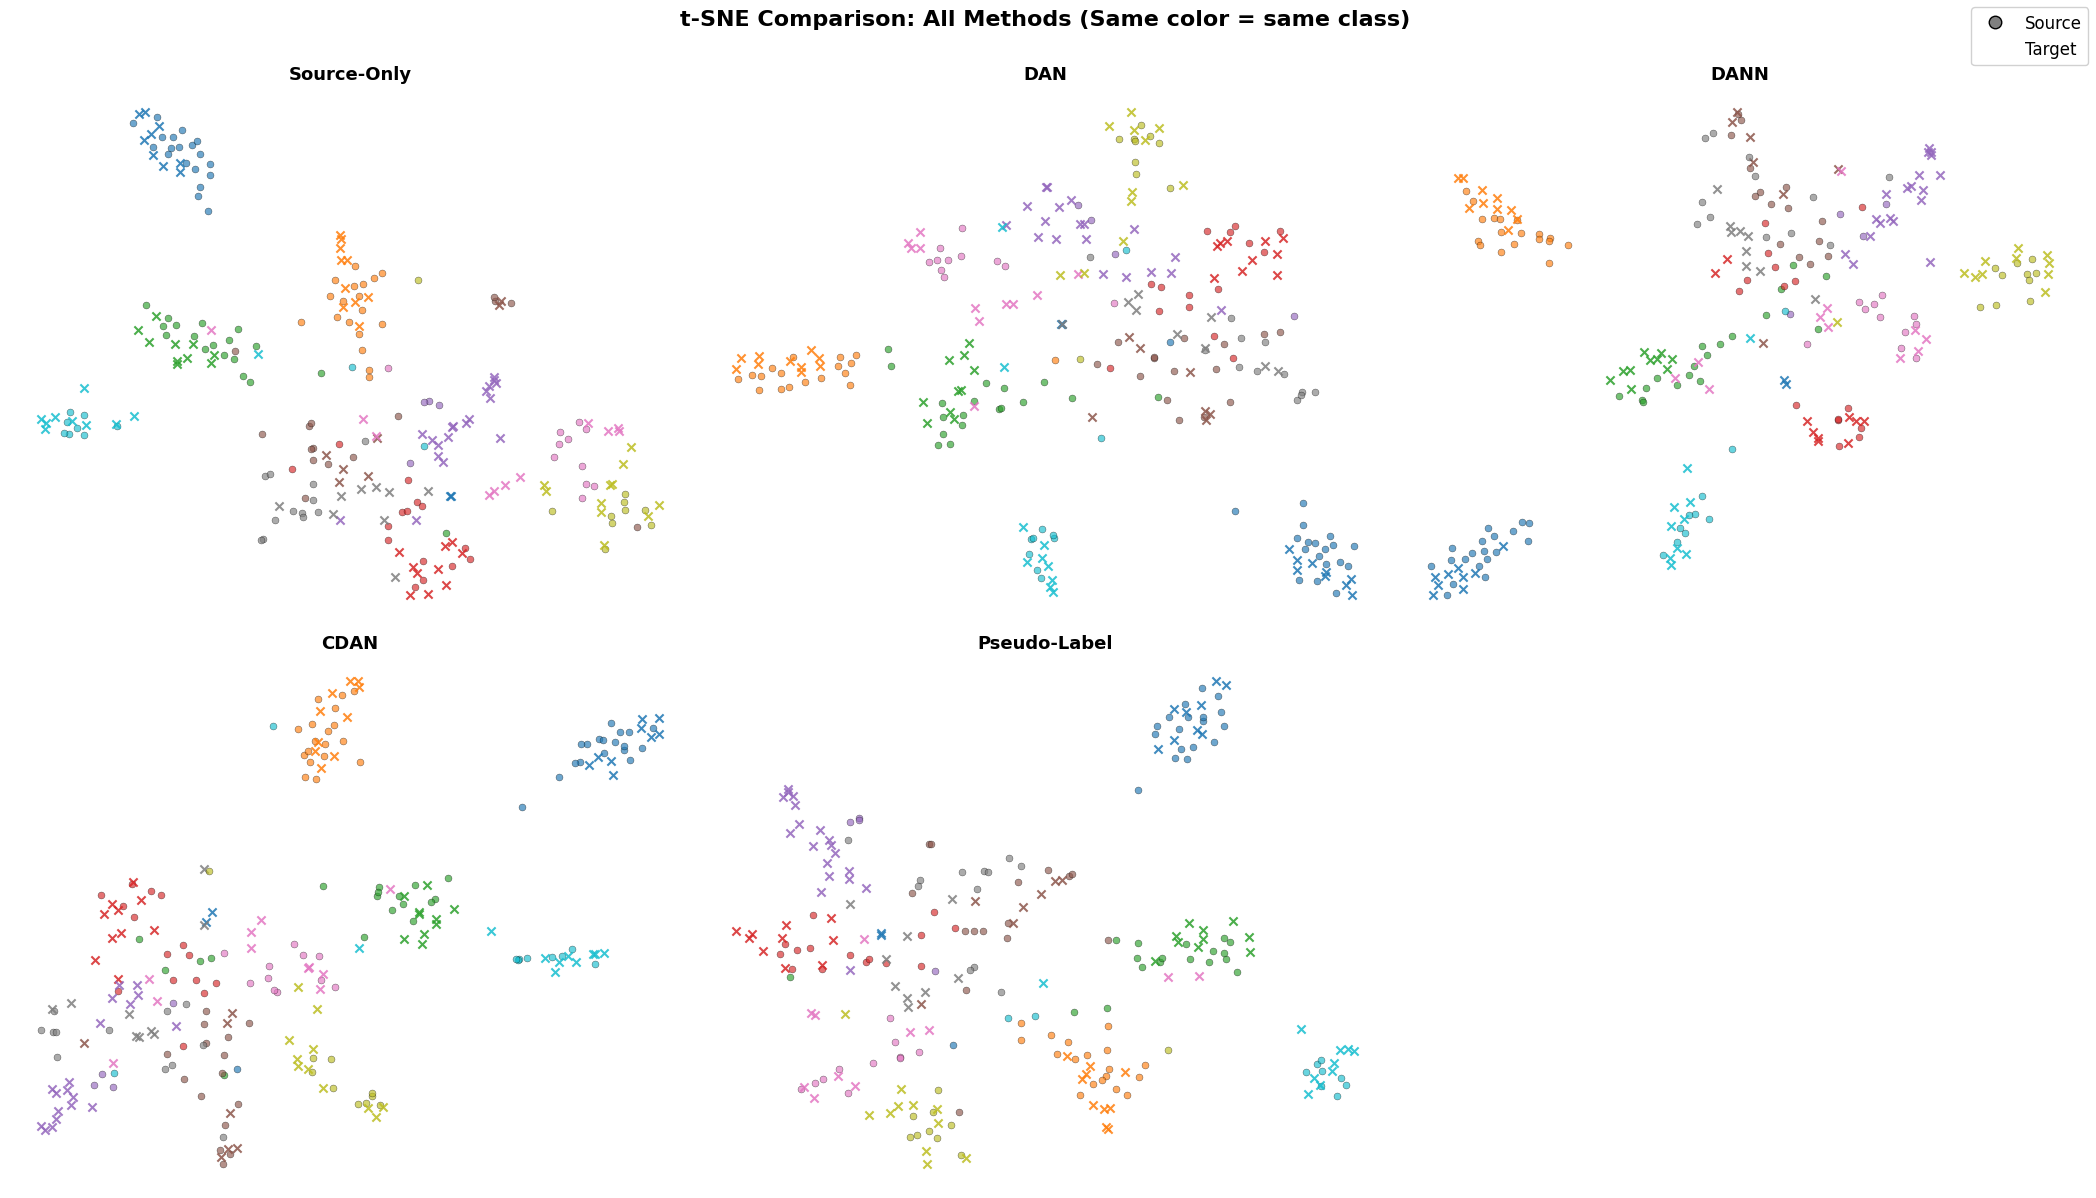


Creating Confusion Matrix Grid
Processing Source-Only (1/5)...
Processing DAN (2/5)...
Processing DANN (3/5)...
Processing CDAN (4/5)...
Processing Pseudo-Label (5/5)...
✓ Saved: viz_outputs/confusion_all_methods_grid.png


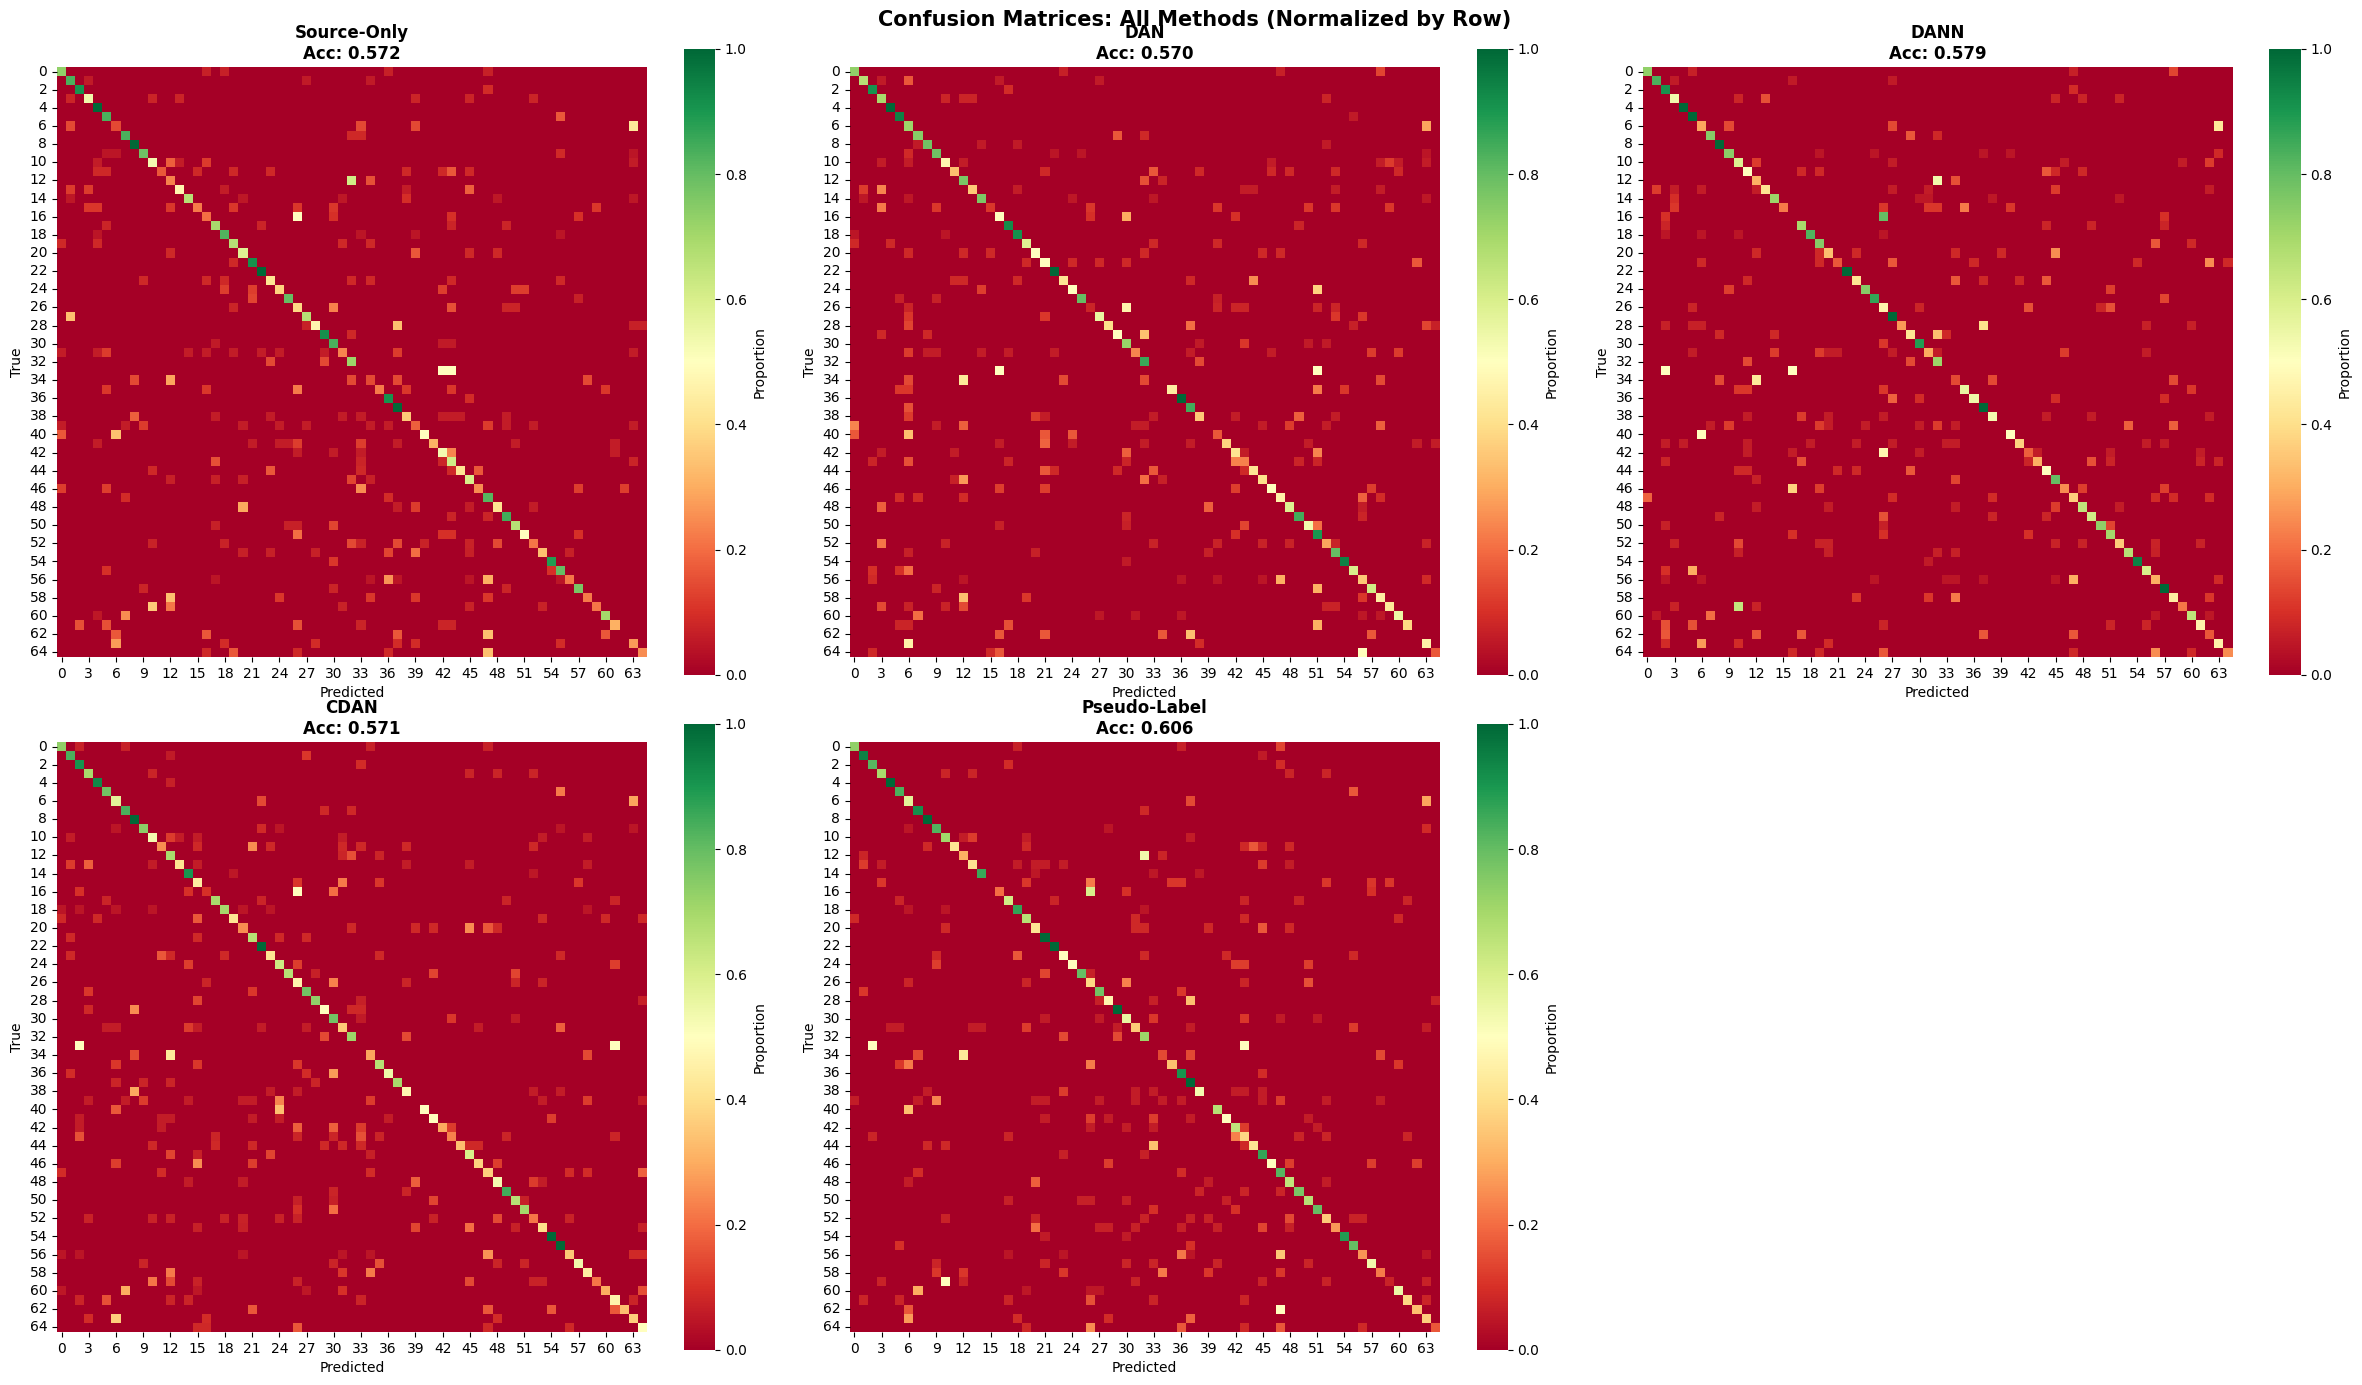


██████████████████████████████████████████████████████████████████████
PART 3: COMPARATIVE ANALYSES
██████████████████████████████████████████████████████████████████████

Creating Per-Class Accuracy Heatmap
Processing Source-Only...
Processing DAN...
Processing DANN...
Processing CDAN...
Processing Pseudo-Label...
✓ Saved: viz_outputs/per_class_accuracy_heatmap.png


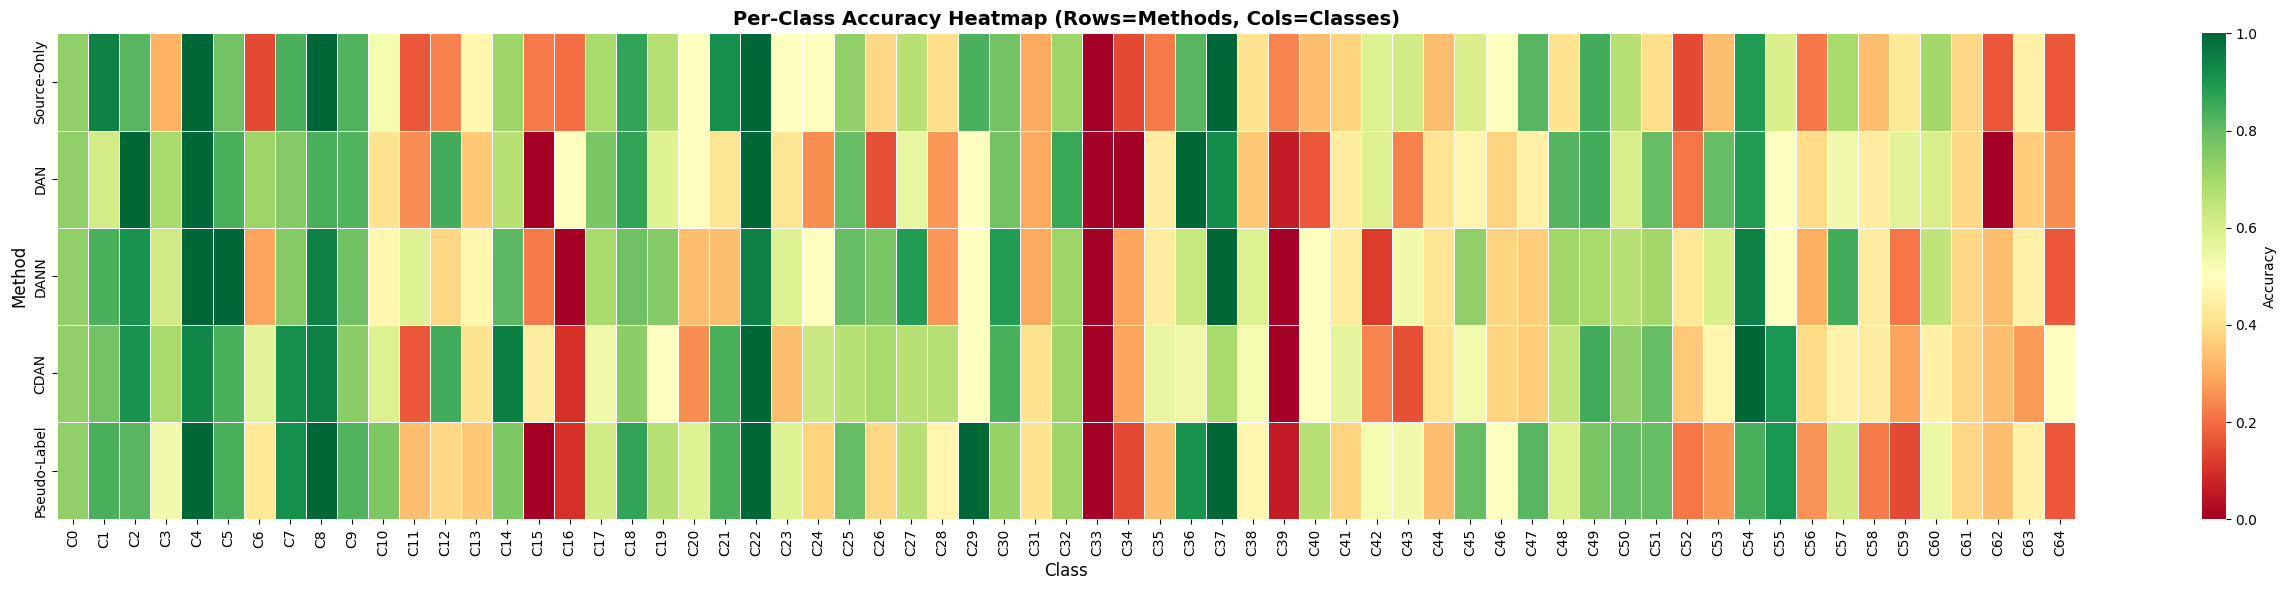


Comparing Performance on 3 Rarest Classes
Rarest 3 classes: [33 40 62]
Class counts: [2 6 6]
Evaluating Source-Only...
Evaluating DAN...
Evaluating DANN...
Evaluating CDAN...
Evaluating Pseudo-Label...
✓ Saved: viz_outputs/rare_class_comparison.png


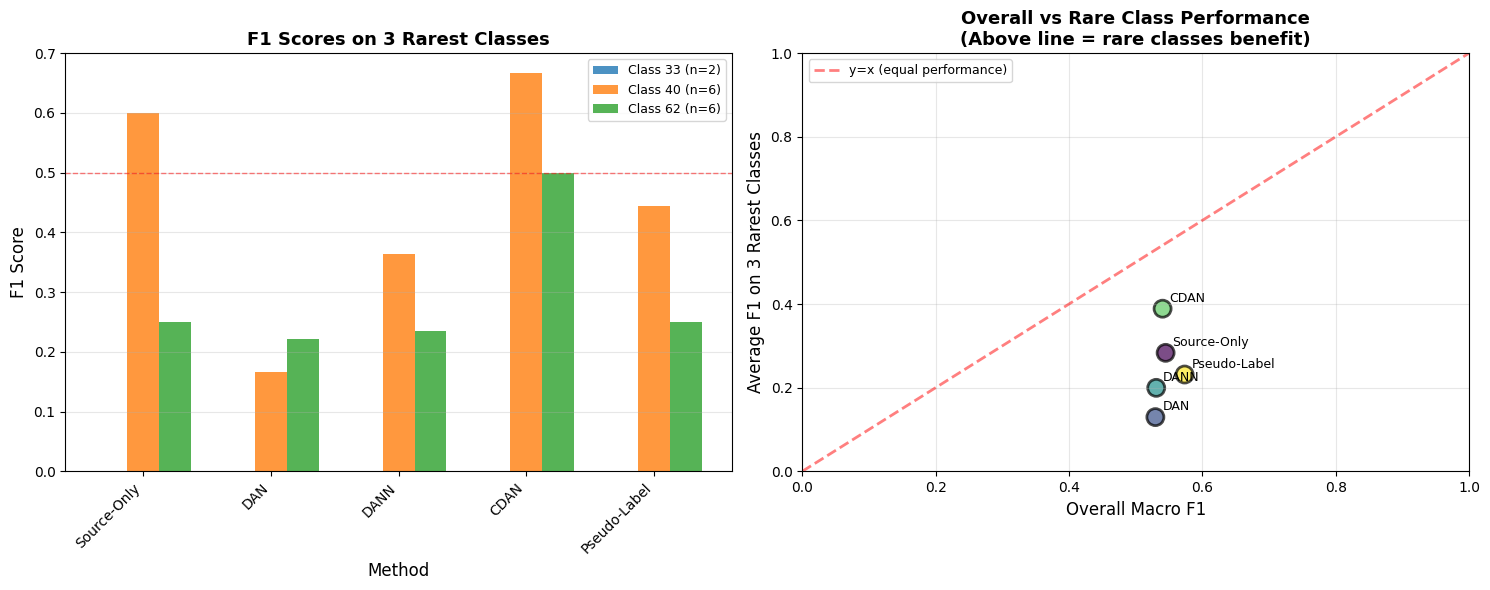


------------------------------------------------------------
RARE CLASS PERFORMANCE SUMMARY
------------------------------------------------------------
Source-Only          | Overall F1: 0.5450 | Rare Avg F1: 0.2833 | Diff: -0.2616
DAN                  | Overall F1: 0.5296 | Rare Avg F1: 0.1296 | Diff: -0.4000
DANN                 | Overall F1: 0.5309 | Rare Avg F1: 0.1996 | Diff: -0.3312
CDAN                 | Overall F1: 0.5404 | Rare Avg F1: 0.3889 | Diff: -0.1515
Pseudo-Label         | Overall F1: 0.5735 | Rare Avg F1: 0.2315 | Diff: -0.3420
------------------------------------------------------------

✓ COMPLETE VISUALIZATION SUITE FINISHED

All results saved to: viz_outputs/

Generated files:
  Per-model folders:
    - Source-Only/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png
      ├── per_class_metrics.png
      └── metrics_summary.txt
    - DAN/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png
 

In [60]:
run_complete_visualization_suite(
    models_dict={
        'Source-Only': feat_ext_source,
        'DAN': feat_ext_dan,
        'DANN': feat_ext_dann,
        'CDAN': feat_ext_cdan,
        'Pseudo-Label': feat_ext_pseudo
    },
    classifiers_dict={
        'Source-Only': cls_source,
        'DAN': cls_dan,
        'DANN': cls_dann,
        'CDAN': cls_cdan,
        'Pseudo-Label': cls_pseudo
    },
    source_dataset=source_test,
    target_dataset=target_test,
    source_test_loader=source_test_loader,
    target_test_loader=target_test_loader,
    num_classes=NUM_CLASSES,
    class_names=None,  # or None
    output_dir='viz_outputs',
    max_tsne_samples=1000,
    show_classes=None  # Auto-select if >15 classes
)

## 6. Experiment 3: Self-Training with Pseudo-Labeling


In [54]:
def self_training(feature_extractor, classifier, target_loader, confidence_thresh=0.9,
                 num_epochs=10, lr=1e-4):
    """Self-training with pseudo-labeling"""
    # Generate pseudo-labels
    feature_extractor.eval()
    classifier.eval()

    pseudo_samples = []

    with torch.no_grad():
        for images, _ in tqdm(target_loader, desc="Generating pseudo-labels"):
            images = images.to(device)
            features = feature_extractor(images)
            outputs = classifier(features)
            probs = torch.softmax(outputs, dim=1)
            max_probs, pseudo_labels = probs.max(1)

            # Filter by confidence
            confident_mask = max_probs > confidence_thresh
            for i in range(len(images)):
                if confident_mask[i]:
                    pseudo_samples.append((images[i].cpu(), pseudo_labels[i].cpu()))

    print(f"Generated {len(pseudo_samples)} pseudo-labeled samples")

    # Fine-tune on pseudo-labels
    feature_extractor.train()
    classifier.train()

    optimizer = optim.Adam(list(feature_extractor.parameters()) +
                          list(classifier.parameters()), lr=lr)
    criterion = nn.CrossEntropyLoss()

    # Create pseudo-label dataloader
    if len(pseudo_samples) == 0:
        print('No pseudo samples found; skipping fine-tuning')
        return feature_extractor, classifier

    pseudo_images = torch.stack([s[0] for s in pseudo_samples])
    pseudo_labels = torch.stack([s[1] for s in pseudo_samples])
    pseudo_dataset = torch.utils.data.TensorDataset(pseudo_images, pseudo_labels)
    pseudo_loader = DataLoader(pseudo_dataset, batch_size=32, shuffle=True)

    for epoch in range(num_epochs):
        total_loss = 0
        for images, labels in tqdm(pseudo_loader, desc=f"Self-train Epoch {epoch+1}/{num_epochs}"):
            images, labels = images.to(device), labels.to(device)

            features = feature_extractor(images)
            outputs = classifier(features)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}: Loss={total_loss/len(pseudo_loader):.4f}")

    return feature_extractor, classifier


In [55]:
print("Self-Training with Pseudo-Labeling...")
# Start from source-only model
feat_ext_pseudo = FeatureExtractor().to(device)
cls_pseudo = Classifier(2048, NUM_CLASSES).to(device)
feat_ext_pseudo.load_state_dict(feat_ext_source.state_dict())
cls_pseudo.load_state_dict(cls_source.state_dict())

feat_ext_pseudo, cls_pseudo = self_training(feat_ext_pseudo, cls_pseudo, DataLoader(target_train, batch_size=32, shuffle=True),
                                            confidence_thresh=0.9, num_epochs=20)

# Evaluate
source_acc_pseudo, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, source_test_loader)
target_acc_pseudo, _, _, _ = evaluate(feat_ext_pseudo, cls_pseudo, target_test_loader)

print(f"\n{'='*50}")
print(f"Psuedo-label training RESULTS:")
print(f"Source Test Accuracy: {source_acc_pseudo:.2f}%")
print(f"Target Test Accuracy: {target_acc_pseudo:.2f}%")
print(f"Accuracy Drop: {source_acc_pseudo - target_acc_pseudo:.2f}%")
print(f"{'='*50}\n")


# print(f"Pseudo-label - Source Acc: {source_acc_pseudo:.2f}%, Target Acc: {target_acc_pseudo:.2f}%")
results['Pseudo-Label'] = {'source_acc': source_acc_pseudo, 'target_acc': target_acc_pseudo}


Self-Training with Pseudo-Labeling...


Generating pseudo-labels: 100%|██████████| 109/109 [01:44<00:00,  1.04it/s]


Generated 2013 pseudo-labeled samples


Self-train Epoch 1/20: 100%|██████████| 63/63 [00:11<00:00,  5.32it/s]


Epoch 1: Loss=0.2106


Self-train Epoch 2/20: 100%|██████████| 63/63 [00:11<00:00,  5.35it/s]


Epoch 2: Loss=0.1230


Self-train Epoch 3/20: 100%|██████████| 63/63 [00:10<00:00,  5.83it/s]


Epoch 3: Loss=0.0926


Self-train Epoch 4/20: 100%|██████████| 63/63 [00:10<00:00,  6.14it/s]


Epoch 4: Loss=0.0697


Self-train Epoch 5/20: 100%|██████████| 63/63 [00:10<00:00,  6.17it/s]


Epoch 5: Loss=0.0852


Self-train Epoch 6/20: 100%|██████████| 63/63 [00:10<00:00,  6.13it/s]


Epoch 6: Loss=0.0501


Self-train Epoch 7/20: 100%|██████████| 63/63 [00:10<00:00,  5.84it/s]


Epoch 7: Loss=0.0376


Self-train Epoch 8/20: 100%|██████████| 63/63 [00:11<00:00,  5.50it/s]


Epoch 8: Loss=0.0287


Self-train Epoch 9/20: 100%|██████████| 63/63 [00:11<00:00,  5.59it/s]


Epoch 9: Loss=0.0232


Self-train Epoch 10/20: 100%|██████████| 63/63 [00:10<00:00,  5.78it/s]


Epoch 10: Loss=0.0214


Self-train Epoch 11/20: 100%|██████████| 63/63 [00:10<00:00,  5.90it/s]


Epoch 11: Loss=0.0220


Self-train Epoch 12/20: 100%|██████████| 63/63 [00:10<00:00,  5.96it/s]


Epoch 12: Loss=0.0217


Self-train Epoch 13/20: 100%|██████████| 63/63 [00:10<00:00,  5.93it/s]


Epoch 13: Loss=0.0194


Self-train Epoch 14/20: 100%|██████████| 63/63 [00:10<00:00,  5.86it/s]


Epoch 14: Loss=0.0126


Self-train Epoch 15/20: 100%|██████████| 63/63 [00:10<00:00,  5.79it/s]


Epoch 15: Loss=0.0114


Self-train Epoch 16/20: 100%|██████████| 63/63 [00:11<00:00,  5.72it/s]


Epoch 16: Loss=0.0096


Self-train Epoch 17/20: 100%|██████████| 63/63 [00:10<00:00,  5.75it/s]


Epoch 17: Loss=0.0117


Self-train Epoch 18/20: 100%|██████████| 63/63 [00:10<00:00,  5.81it/s]


Epoch 18: Loss=0.0125


Self-train Epoch 19/20: 100%|██████████| 63/63 [00:10<00:00,  5.81it/s]


Epoch 19: Loss=0.0090


Self-train Epoch 20/20: 100%|██████████| 63/63 [00:10<00:00,  5.83it/s]


Epoch 20: Loss=0.0107

Psuedo-label training RESULTS:
Source Test Accuracy: 63.17%
Target Test Accuracy: 60.67%
Accuracy Drop: 2.50%



In [ ]:
# run_all_viz_for_model("Psuedo-label", feat_ext_pseudo, cls_pseudo, source_train, target_test, source_test_loader, target_test_loader,
#                       exp_name="original", output_dir="viz_outputs", tsne_samples=800)


### Analysis: Domain Adaptation Methods Comparison

**Key Findings:**
1. **DAN** (MMD-based): Statistical alignment reduces domain divergence
2. **DANN** (Adversarial): Learns domain-invariant features through adversarial training
3. **CDAN** (Class-aware): Conditions alignment on predictions to prevent negative transfer
4. **Pseudo-labeling**: Simple yet effective, leverages target structure

**Trade-offs Observed:**
- Alignment methods may slightly decrease source accuracy (discriminative features affected)
- Class-aware methods (CDAN) better preserve class boundaries
- Pseudo-labeling risk: confirmation bias on incorrect predictions

### 6.1. Summary till now + F1

In [61]:
classifiers_dict = {
    'Source-Only': cls_source,
    'DAN': cls_dan,
    'DANN': cls_dann,
    'CDAN': cls_cdan,
    'Pseudo-Label': cls_pseudo
}

In [62]:
print("\n" + "="*70)
print("FINAL RESULTS SUMMARY")
print("="*70)
print(f"{'Method':<20} {'Source Acc (%)':<18} {'Target Acc (%)':<18} {'Gain (%)':<12}")
print("-"*70)

baseline_target = results['Source-Only']['target_acc']
for method, res in results.items():
    gain = res['target_acc'] - baseline_target
    print(f"{method:<20} {res['source_acc']:<18.2f} {res['target_acc']:<18.2f} {gain:+<12.2f}")
print("="*70 + "\n")


FINAL RESULTS SUMMARY
Method               Source Acc (%)     Target Acc (%)     Gain (%)    
----------------------------------------------------------------------
Source-Only          63.17              57.22              0.00++++++++
DAN                  60.91              55.50              -1.72+++++++
DANN                 63.79              57.22              0.00++++++++
CDAN                 60.91              57.57              0.34++++++++
Pseudo-Label         63.17              60.67              3.44++++++++



### t-SNE Analysis

**Observations:**
- **Source-Only**: Clear separation between source (blue) and target (red) - domains not aligned
- **DAN/DANN/CDAN**: Reduced separation - domains becoming more aligned
- **Best alignment**: Look for overlap while preserving class clusters
- **Class-aware methods** (CDAN) should maintain better class separation

In [69]:
import shutil

shutil.make_archive('/kaggle/working/viz_outputs', 'zip', 'viz_outputs')


'/kaggle/working/viz_outputs.zip'

## 7. Experiment 4: Concept Shift Simulation
Simulate label/concept shift by modifying target class distribution

In [65]:
training_functions = {
    "Source Only": train_source_only,     # Baseline model trained only on source
    "DAN": train_dan,                     # Deep Adaptation Network (MMD-based)
    "DANN": train_dann,                   # Domain-Adversarial Neural Network
    "CDAN": train_cdan,                   # Conditional Domain-Adversarial Network
    "Self-Training": self_training,  # Pseudo-label/self-training variant
}

### 7.1 rare class scenario

In [74]:
import random
import copy

def create_rare_class_dataset(dataset, rare_class, reduction_ratio=0.2):
    """Return a dataset where one class (rare_class) is underrepresented."""
    
    # Handle both Subset and normal dataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = range(len(dataset))
    
    # Collect samples and labels
    samples = []
    for idx in indices:
        item = base_dataset[idx]
        samples.append((idx, item[1]))  # (index, label)
    
    # Separate rare vs non-rare
    rare_indices = [idx for idx, label in samples if label == rare_class]
    non_rare_indices = [idx for idx, label in samples if label != rare_class]
    
    reduced_rare = random.sample(rare_indices, max(1, int(len(rare_indices) * reduction_ratio)))
    final_indices = non_rare_indices + reduced_rare
    
    print(f"Rare-class {rare_class}: kept {len(reduced_rare)}/{len(rare_indices)} samples")

    # Create a new Subset dataset
    rare_dataset = torch.utils.data.Subset(base_dataset, final_indices)
    return rare_dataset


In [76]:
# Identify rarest class (for your rare-class test)
class_counts = {}
# for _, label in target_train.indices:
#     class_counts[label] = class_counts.get(label, 0) + 1
# class_counts = {}
# for idx in target_train.indices:
#     _, label = full_target.samples[idx]
#     class_counts[label] = class_counts.get(label, 0) + 1
# rarest_classes = sorted(class_counts, key=class_counts.get)
rare_class = 3
# rarest_classes[0]

# Rare class dataset (20% of its original samples)
target_rare = create_rare_class_dataset(target_train, rare_class, reduction_ratio=0.2)
target_rare_loader = DataLoader(target_rare, batch_size=32, shuffle=True, num_workers=4)

Rare-class 3: kept 14/70 samples


In [77]:
shifted_results_rare = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    classifier = classifiers_dict[name]
    acc, preds, labels, _ = evaluate(model, classifier, target_rare_loader)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)

    shifted_results_rare[name] = {'accuracy': acc, 'f1_macro': f1_macro}
    print(f"{name:<20} Accuracy: {acc:.2f}%, F1-Macro: {f1_macro:.4f}")


Evaluating Source-Only...
Source-Only          Accuracy: 57.54%, F1-Macro: 0.5408

Evaluating DAN...
DAN                  Accuracy: 54.91%, F1-Macro: 0.5145

Evaluating DANN...
DANN                 Accuracy: 56.20%, F1-Macro: 0.5236

Evaluating CDAN...
CDAN                 Accuracy: 57.07%, F1-Macro: 0.5343

Evaluating Pseudo-Label...
Pseudo-Label         Accuracy: 60.13%, F1-Macro: 0.5630



COMPLETE VISUALIZATION SUITE
Number of methods: 5
Output directory: rare_outputs


██████████████████████████████████████████████████████████████████████
PART 1: PER-MODEL DETAILED VISUALIZATIONS
██████████████████████████████████████████████████████████████████████

Visualizing: Source-Only
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: rare_outputs/Source-Only/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DAN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: rare_outputs/DAN/
  - random_images.png
  - tsne_dual_view.png
  - confusion_matrix.png
  - per_class_metrics.png
  - metrics_summary.txt

Visualizing: DANN
2/4 Computing t-SNE...
3/4 Generating confusion matrix...
4/4 Computing per-class metrics...
✓ All visualizations saved to: rare_outputs/

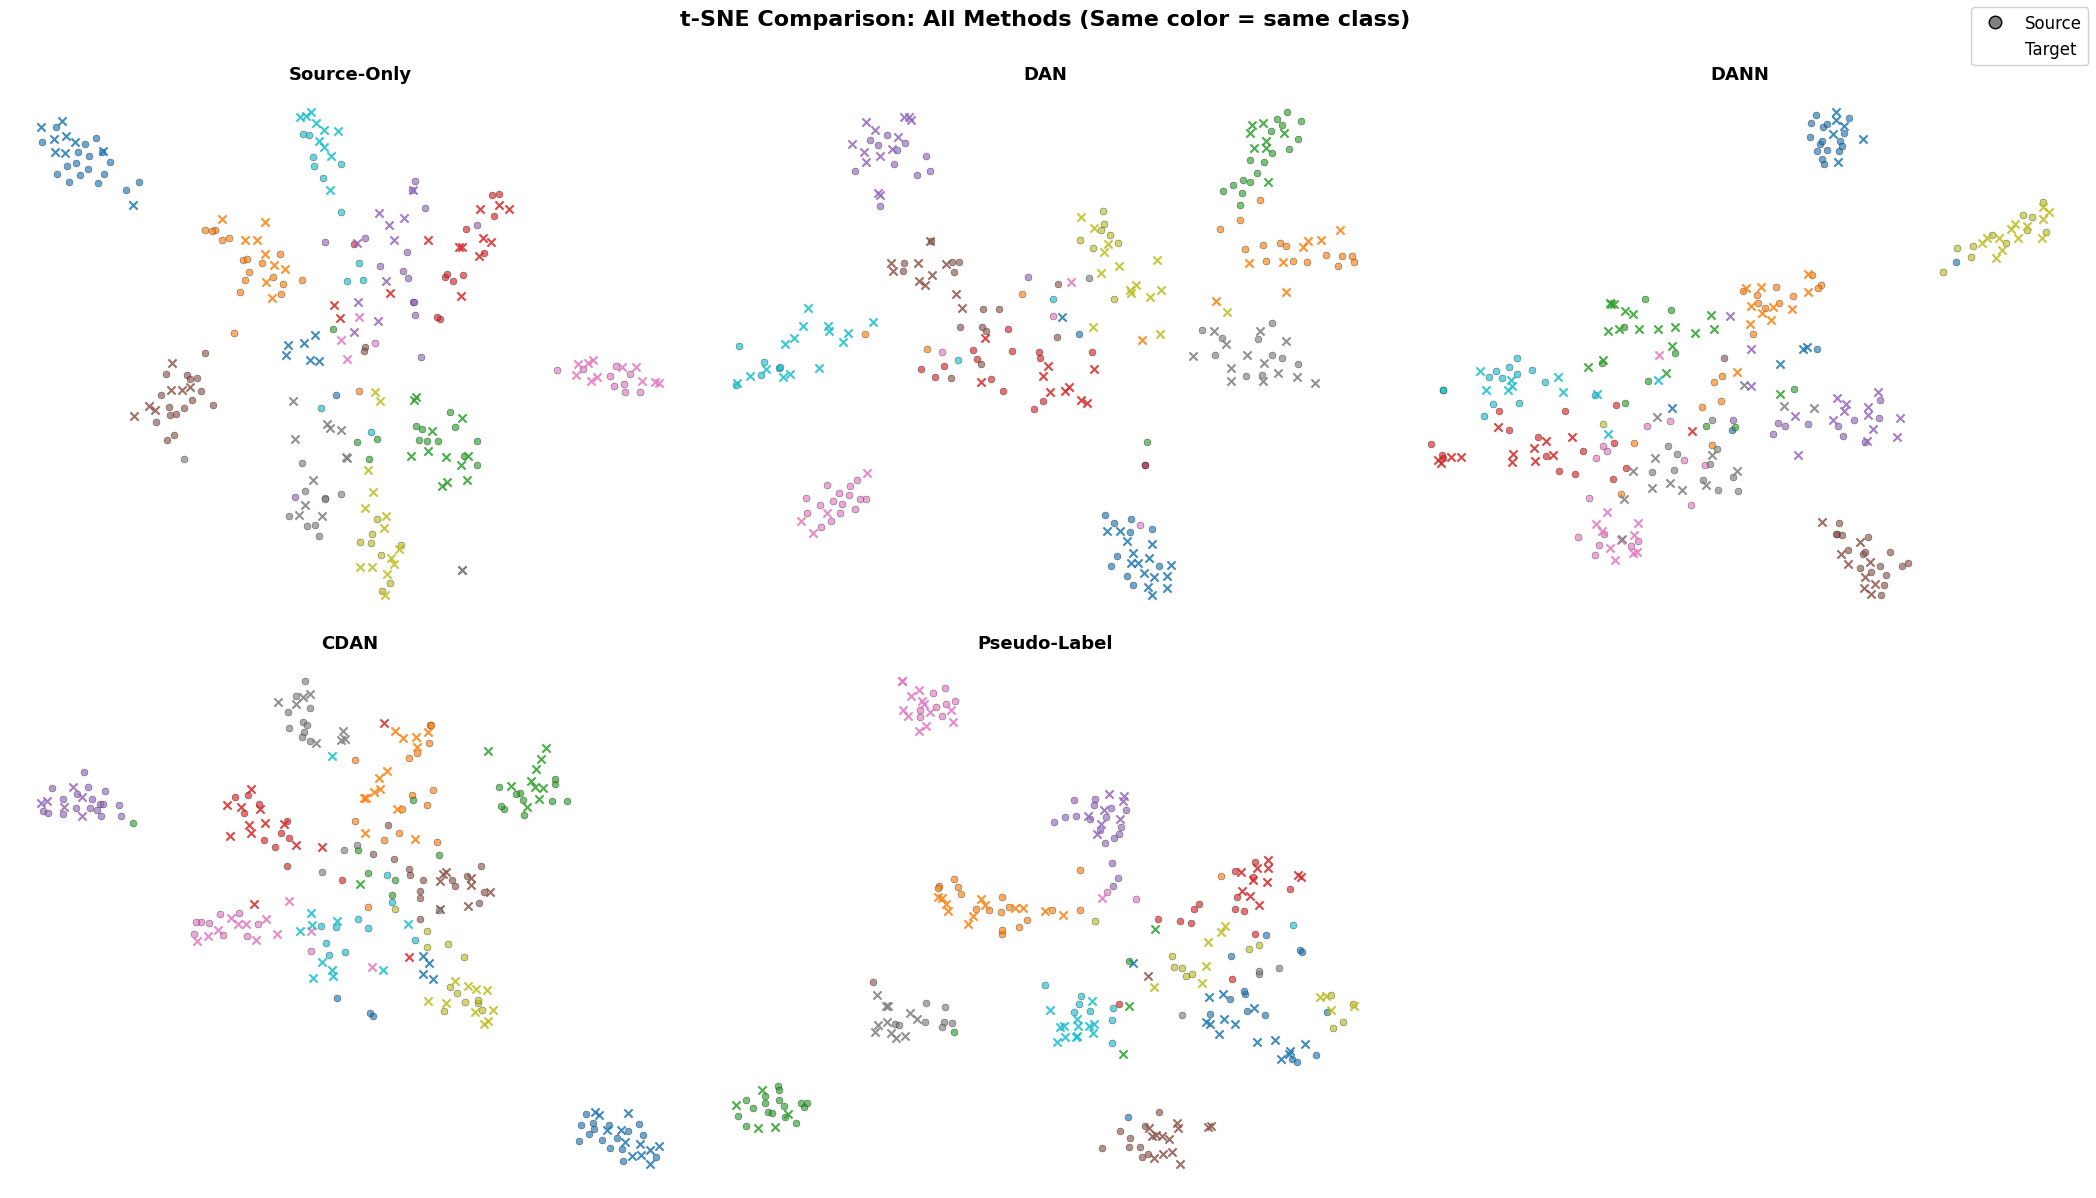


Creating Confusion Matrix Grid
Processing Source-Only (1/5)...
Processing DAN (2/5)...
Processing DANN (3/5)...
Processing CDAN (4/5)...
Processing Pseudo-Label (5/5)...
✓ Saved: rare_outputs/confusion_all_methods_grid.png


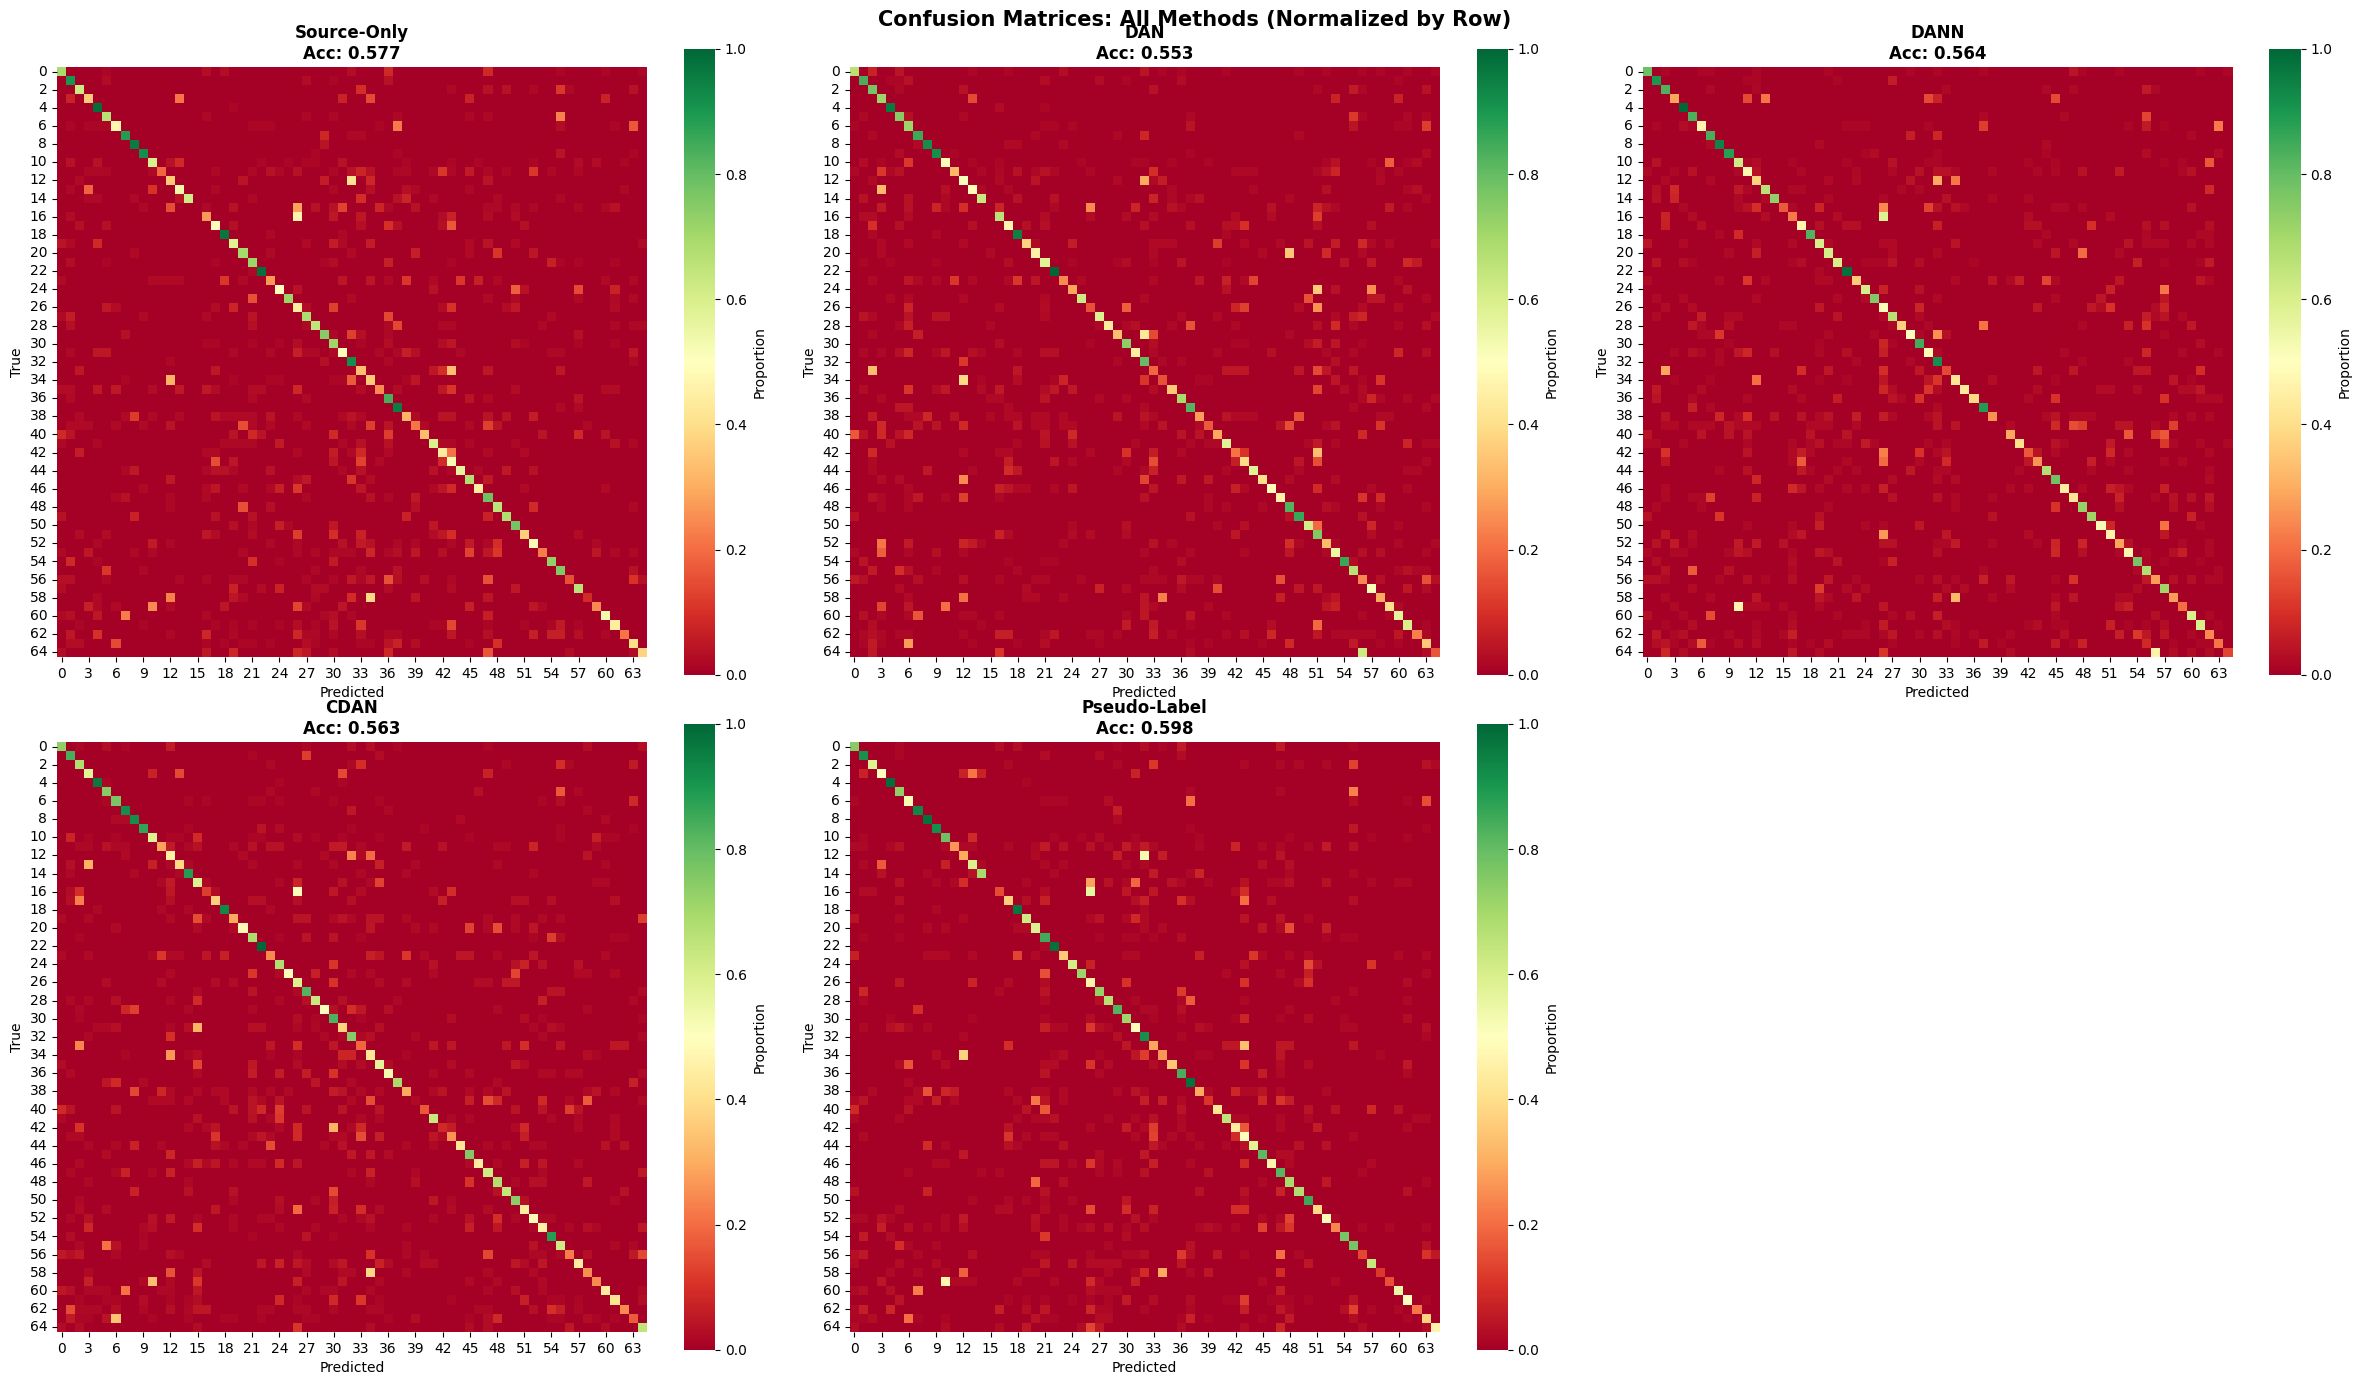


██████████████████████████████████████████████████████████████████████
PART 3: COMPARATIVE ANALYSES
██████████████████████████████████████████████████████████████████████

Creating Per-Class Accuracy Heatmap
Processing Source-Only...
Processing DAN...
Processing DANN...
Processing CDAN...
Processing Pseudo-Label...
✓ Saved: rare_outputs/per_class_accuracy_heatmap.png


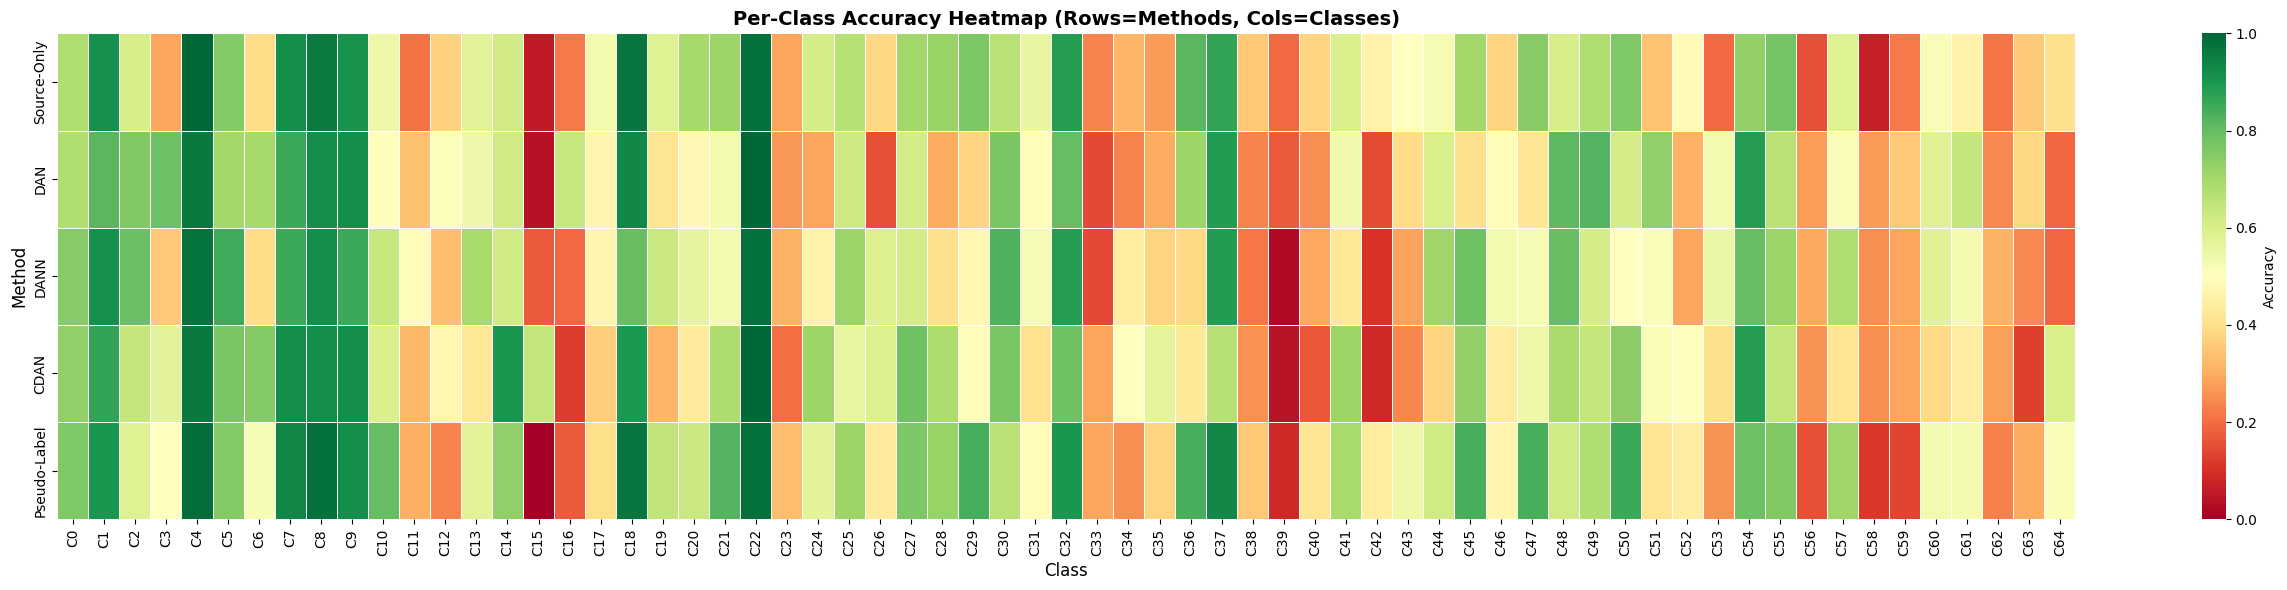


Comparing Performance on 3 Rarest Classes
Rarest 3 classes: [ 3 33 40]
Class counts: [14 21 24]
Evaluating Source-Only...
Evaluating DAN...
Evaluating DANN...
Evaluating CDAN...
Evaluating Pseudo-Label...
✓ Saved: rare_outputs/rare_class_comparison.png


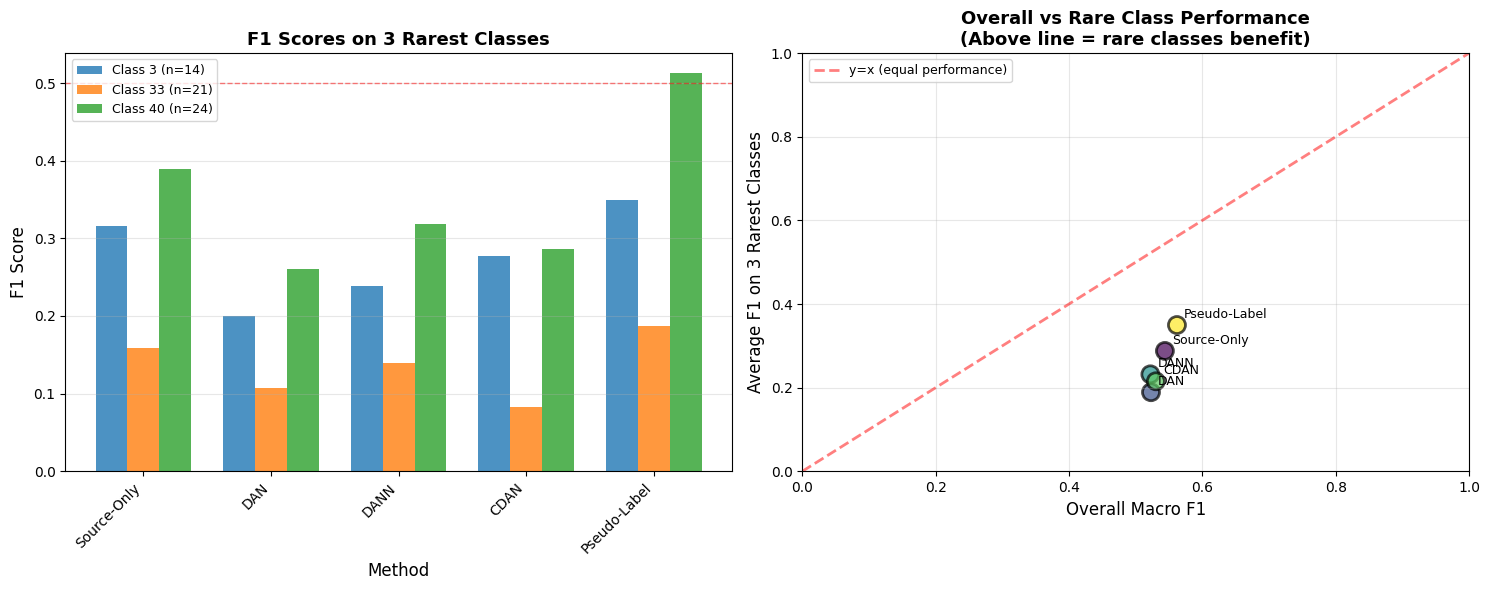


------------------------------------------------------------
RARE CLASS PERFORMANCE SUMMARY
------------------------------------------------------------
Source-Only          | Overall F1: 0.5439 | Rare Avg F1: 0.2879 | Diff: -0.2560
DAN                  | Overall F1: 0.5230 | Rare Avg F1: 0.1892 | Diff: -0.3338
DANN                 | Overall F1: 0.5221 | Rare Avg F1: 0.2319 | Diff: -0.2902
CDAN                 | Overall F1: 0.5303 | Rare Avg F1: 0.2153 | Diff: -0.3150
Pseudo-Label         | Overall F1: 0.5620 | Rare Avg F1: 0.3498 | Diff: -0.2121
------------------------------------------------------------

✓ COMPLETE VISUALIZATION SUITE FINISHED

All results saved to: rare_outputs/

Generated files:
  Per-model folders:
    - Source-Only/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png
      ├── per_class_metrics.png
      └── metrics_summary.txt
    - DAN/
      ├── random_images.png
      ├── tsne_dual_view.png
      ├── confusion_matrix.png


In [78]:
run_complete_visualization_suite(
    models_dict={
        'Source-Only': feat_ext_source,
        'DAN': feat_ext_dan,
        'DANN': feat_ext_dann,
        'CDAN': feat_ext_cdan,
        'Pseudo-Label': feat_ext_pseudo
    },
    classifiers_dict={
        'Source-Only': cls_source,
        'DAN': cls_dan,
        'DANN': cls_dann,
        'CDAN': cls_cdan,
        'Pseudo-Label': cls_pseudo
    },
    source_dataset=source_train,
    target_dataset=target_rare,
    source_test_loader=source_test_loader,
    target_test_loader=target_rare_loader,
    num_classes=NUM_CLASSES,
    class_names=None,  # or None
    output_dir='rare_outputs',
    max_tsne_samples=1000,
    show_classes=None  # Auto-select if >15 classes
)

In [79]:
import shutil

shutil.make_archive('/kaggle/working/rare_outputs', 'zip', 'rare_outputs')

'/kaggle/working/rare_outputs.zip'

### 7.2: Label Shift

In [82]:
def create_label_shift_dataset(dataset, classes_to_remove):
    """Return dataset with certain classes completely removed."""
    
    # Handle both Subset and normal dataset
    if isinstance(dataset, torch.utils.data.Subset):
        base_dataset = dataset.dataset
        indices = dataset.indices
    else:
        base_dataset = dataset
        indices = range(len(dataset))
    
    # Keep only samples whose label is NOT in classes_to_remove
    kept_indices = []
    for idx in indices:
        _, label = base_dataset[idx]
        if label not in classes_to_remove:
            kept_indices.append(idx)
    
    print(f"Label shift: removed classes {classes_to_remove}, kept {len(kept_indices)}/{len(indices)} samples")

    shifted_dataset = torch.utils.data.Subset(base_dataset, kept_indices)
    return shifted_dataset

classes_to_remove = 5,15, 37
# rarest_classes[5, 15, 37]
target_label_shift = create_label_shift_dataset(target_train, classes_to_remove)
target_label_shift_loader = DataLoader(target_label_shift, batch_size=32, shuffle=True, num_workers=4)

print(f"\nOriginal target samples: {len(target_test)}")
print(f"Shifted target samples: {len(target_label_shift)}")


Label shift: removed classes (5, 15, 37), kept 3327/3485 samples

Original target samples: 872
Shifted target samples: 3327


In [83]:
print("\nTraining on Label-Shifted Target Domain...")
print("-"*70)

label_shift_models, label_shift_classifiers = {}, {}
shifted_results_label = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    classifier = classifiers_dict[name]
    acc, preds, labels, _ = evaluate(model, classifier, target_label_shift_loader)
    f1_macro = f1_score(labels, preds, average='macro', zero_division=0)

    shifted_results_label[name] = {'accuracy': acc, 'f1_macro': f1_macro}
    print(f"{name:<20} Accuracy: {acc:.2f}%, F1-Macro: {f1_macro:.4f}")

print("-"*70)


Training on Label-Shifted Target Domain...
----------------------------------------------------------------------

Evaluating Source-Only...
Source-Only          Accuracy: 57.35%, F1-Macro: 0.5308

Evaluating DAN...
DAN                  Accuracy: 55.91%, F1-Macro: 0.5087

Evaluating DANN...
DANN                 Accuracy: 56.66%, F1-Macro: 0.5145

Evaluating CDAN...
CDAN                 Accuracy: 56.21%, F1-Macro: 0.5092

Evaluating Pseudo-Label...
Pseudo-Label         Accuracy: 59.96%, F1-Macro: 0.5547
----------------------------------------------------------------------


In [ ]:
run_complete_visualization_suite(
    models_dict={
        'Source-Only': feat_ext_source,
        'DAN': feat_ext_dan,
        'DANN': feat_ext_dann,
        'CDAN': feat_ext_cdan,
        'Pseudo-Label': feat_ext_pseudo
    },
    classifiers_dict={
        'Source-Only': cls_source,
        'DAN': cls_dan,
        'DANN': cls_dann,
        'CDAN': cls_cdan,
        'Pseudo-Label': cls_pseudo
    },
    source_dataset=source_train,
    target_dataset=target_label_shift,
    source_test_loader=source_test_loader,
    target_test_loader=target_label_shift_loader,
    num_classes=NUM_CLASSES,
    class_names=None,  # or None
    output_dir='label_shift_outputs',
    max_tsne_samples=1000,
    show_classes=None  # Auto-select if >15 classes
)

In [85]:
import shutil

shutil.make_archive('/kaggle/working/label_shift_outputs', 'zip', 'label_shift_outputs')

'/kaggle/working/label_shift_outputs.zip'

## All Results

In [ ]:
def create_summary_table():
    print("\n" + "="*100)
    print("COMPREHENSIVE RESULTS SUMMARY")
    print("="*100)

    headers = ['Method', 'Source Acc', 'Target Acc', 'Target Gain',
               'Domain Clf Acc', 'A-Distance', 'Rare F1', 'Shifted Acc']

    print(f"{headers[0]:<15} {headers[1]:<12} {headers[2]:<12} {headers[3]:<12} "
          f"{headers[4]:<15} {headers[5]:<12} {headers[6]:<10} {headers[7]:<12}")
    print("-"*100)

    baseline_target = results['Source-Only']['target_acc']

    for name in models.keys():
        source_acc = results[name]['source_acc']
        target_acc = results[name]['target_acc']
        gain = target_acc - baseline_target
        dom_clf_acc = domain_distances[name]['classifier_acc']
        a_dist = domain_distances[name]['a_distance']

        rare_f1 = np.mean([f1_results[name][cls] for cls in rarest_classes])

        shifted_acc = shifted_results[name]['accuracy']

        print(f"{name:<15} {source_acc:<12.2f} {target_acc:<12.2f} {gain:<+12.2f} "
              f"{dom_clf_acc:<15.4f} {a_dist:<12.4f} {rare_f1:<10.4f} {shifted_acc:<12.2f}")

    print("="*100)
    print("\nInterpretation:")
    print("- Target Gain: Improvement over source-only baseline")
    print("- Domain Clf Acc: Lower = better alignment (harder to distinguish domains)")
    print("- A-Distance: Proxy for domain divergence (lower = better)")
    print("- Rare F1: Average F1 on 3 rarest classes (measures negative transfer)")
    print("- Shifted Acc: Performance under label distribution shift")
    print("="*100 + "\n")
create_summary_table()
